We determined that the 'slot_Shape_flag' together with the 'base_PixelFlags_flag_suspect' and 'base_PixelFlags_flag_bad' flags appears to filter out a lot of obviously bad DIASources. In this notebook, we'll make some light curve and cutout plots for DIAObjects composed of "not obviously bad" DIASources.

In [161]:
%matplotlib notebook
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import itertools
import importlib

from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize
import astropy.units as u
import astropy.coordinates as coord

import lsst.geom
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')
from lsst.ap.association import UnpackPpdbFlags, MapDiaSourceConfig
from lsst.utils import getPackageDir

In [162]:
sys.path.append('/project/mrawls/ap_pipe-notebooks/')

In [163]:
from diaObjectAnalysis import loadAllPpdbObjects, loadAllPpdbSources, plotDiaObjectsOnSky #, setObjectFilter
import plotLightcurve as plc  # in_ipynb, loadPpdbObjects, loadPpdbSources, patchFinder, plotLightcurve

In [289]:
# Only if you change anything in the code imported above
importlib.reload(plc)

<module 'plotLightcurve' from '/project/mrawls/ap_pipe-notebooks/plotLightcurve.py'>

In [4]:
repo = '/project/mrawls/hits2015/rerun/cw_processed5'
butler = dafPersist.Butler(repo)
dbPath = os.path.join(repo, 'association.db')

In [6]:
objTable = loadAllPpdbObjects(repo)

That was so fun, we'll just load the entire srcTable into memory while we're at it

In [5]:
srcTable = loadAllPpdbSources(repo)

In [7]:
objTable[0:3]

diaObjectId          ra      decl  nDiaSources    gPSFluxMean  \
0  176486854802014420  150.127929  1.814168            1  129750.843750   
1  176486854802014437  150.151781  1.873059            1   -1901.032959   
2  176486854802014439  150.156033  1.788120            1    2648.088379   

  validityEnd  flags  
0        None      1  
1        None      1  
2        None      0

In [8]:
srcTable[0:3]

diaSourceId         diaObjectId          ra      decl  ccdVisitId  \
0  176486854802014418  176486854802014418  150.128762  1.869404    41091548   
1  176486854802014419  176486854802014419  150.126704  1.863992    41091548   
2  176486854802014420  176486854802014420  150.127929  1.814168    41091548   

    midPointTai         apFlux         psFlux    apFluxErr   psFluxErr  \
0  57070.141866  -13366.519997   -4628.039759  1119.058120  380.759647   
1  57070.141866   -4580.587384   -2128.562288  1107.755119  371.963292   
2  57070.141866  142496.490914  129750.846992   819.128942  508.868694   

         totFlux  totFluxErr     flags  
0   24677.943465  321.743103  25168332  
1   24279.001665  235.240119  25168268  
2  153222.295142  502.009028      2176

In [9]:
len(objTable)

470419

In [10]:
len(srcTable)

1188543

In [13]:
config = MapDiaSourceConfig()
unpacker = UnpackPpdbFlags(config.flagMap, 'DiaSource')
flag_values = unpacker.unpack(srcTable['flags'], 'flags')
flag_names = list(flag_values.dtype.names)

In [14]:
len(flag_values)

1188543

In [19]:
flag_names

['base_PixelFlags_flag',
 'base_PixelFlags_flag_offimage',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_interpolated',
 'base_PixelFlags_flag_saturated',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_suspect',
 'base_PixelFlags_flag_interpolatedCenter',
 'base_PixelFlags_flag_saturatedCenter',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_suspectCenter',
 'slot_Centroid_flag',
 'slot_Centroid_pos_flag',
 'slot_Centroid_neg_flag',
 'slot_ApFlux_flag',
 'slot_ApFlux_flag_apertureTruncated',
 'slot_PsfFlux_flag',
 'slot_PsfFlux_flag_noGoodPixels',
 'slot_PsfFlux_flag_edge',
 'ip_diffim_forced_PsfFlux_flag',
 'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
 'ip_diffim_forced_PsfFlux_flag_edge',
 'slot_Shape_flag',
 'slot_Shape_flag_unweightedBad',
 'slot_Shape_flag_unweighted',
 'slot_Shape_flag_shift',
 'slot_Shape_flag_maxIter',
 'slot_Shape_flag_psf']

In [16]:
flagTable = pd.DataFrame(flag_values, index=srcTable.index)

In [17]:
flagSum = flagTable.sum()

In [65]:
def plot_flag_hist(flags, labels, title=None):
    assert len(flags) == len(labels)
    assert len(flags) == 29  # because we're doing custom slicing below

    fig, ax = plt.subplots(figsize=(9,9))

    pixelflags = ax.barh(labels[0:8], flags[0:8], color='C0')
    pixelcenterflags = ax.barh(labels[8:12], flags[8:12], color='C1')
    centroidflags = ax.barh(labels[12:15], flags[12:15], color='C4')
    apfluxflags = ax.barh(labels[15:17], flags[15:17], color='C5')
    psffluxflags = ax.barh(labels[17:20], flags[17:20], color='C2')
    ip_diffimflags = ax.barh(labels[20:23], flags[20:23], color='C5')
    shapeflags = ax.barh(labels[23::], flags[23::], color='C3')

    #ax.xaxis.set_tick_params(rotation=89)
    fig.subplots_adjust(left=0.35)
    ax.set_xlabel('Number of flagged DIASources')

    ax.legend((pixelflags[0],
               pixelcenterflags[0],
               centroidflags[0],
               apfluxflags[0], 
               psffluxflags[0],
               ip_diffimflags[0],
               shapeflags[0]), 
              ('Pixel flags', 
               'Pixel center flags',
               'Centroid flags',
               'ApFlux flags',
               'PsfFlux flags',
               'ip_diffim flags',
               'Shape flags'),
              frameon=False, loc='upper right', ncol=2
             )

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title(title)

<IPython.core.display.Javascript object>


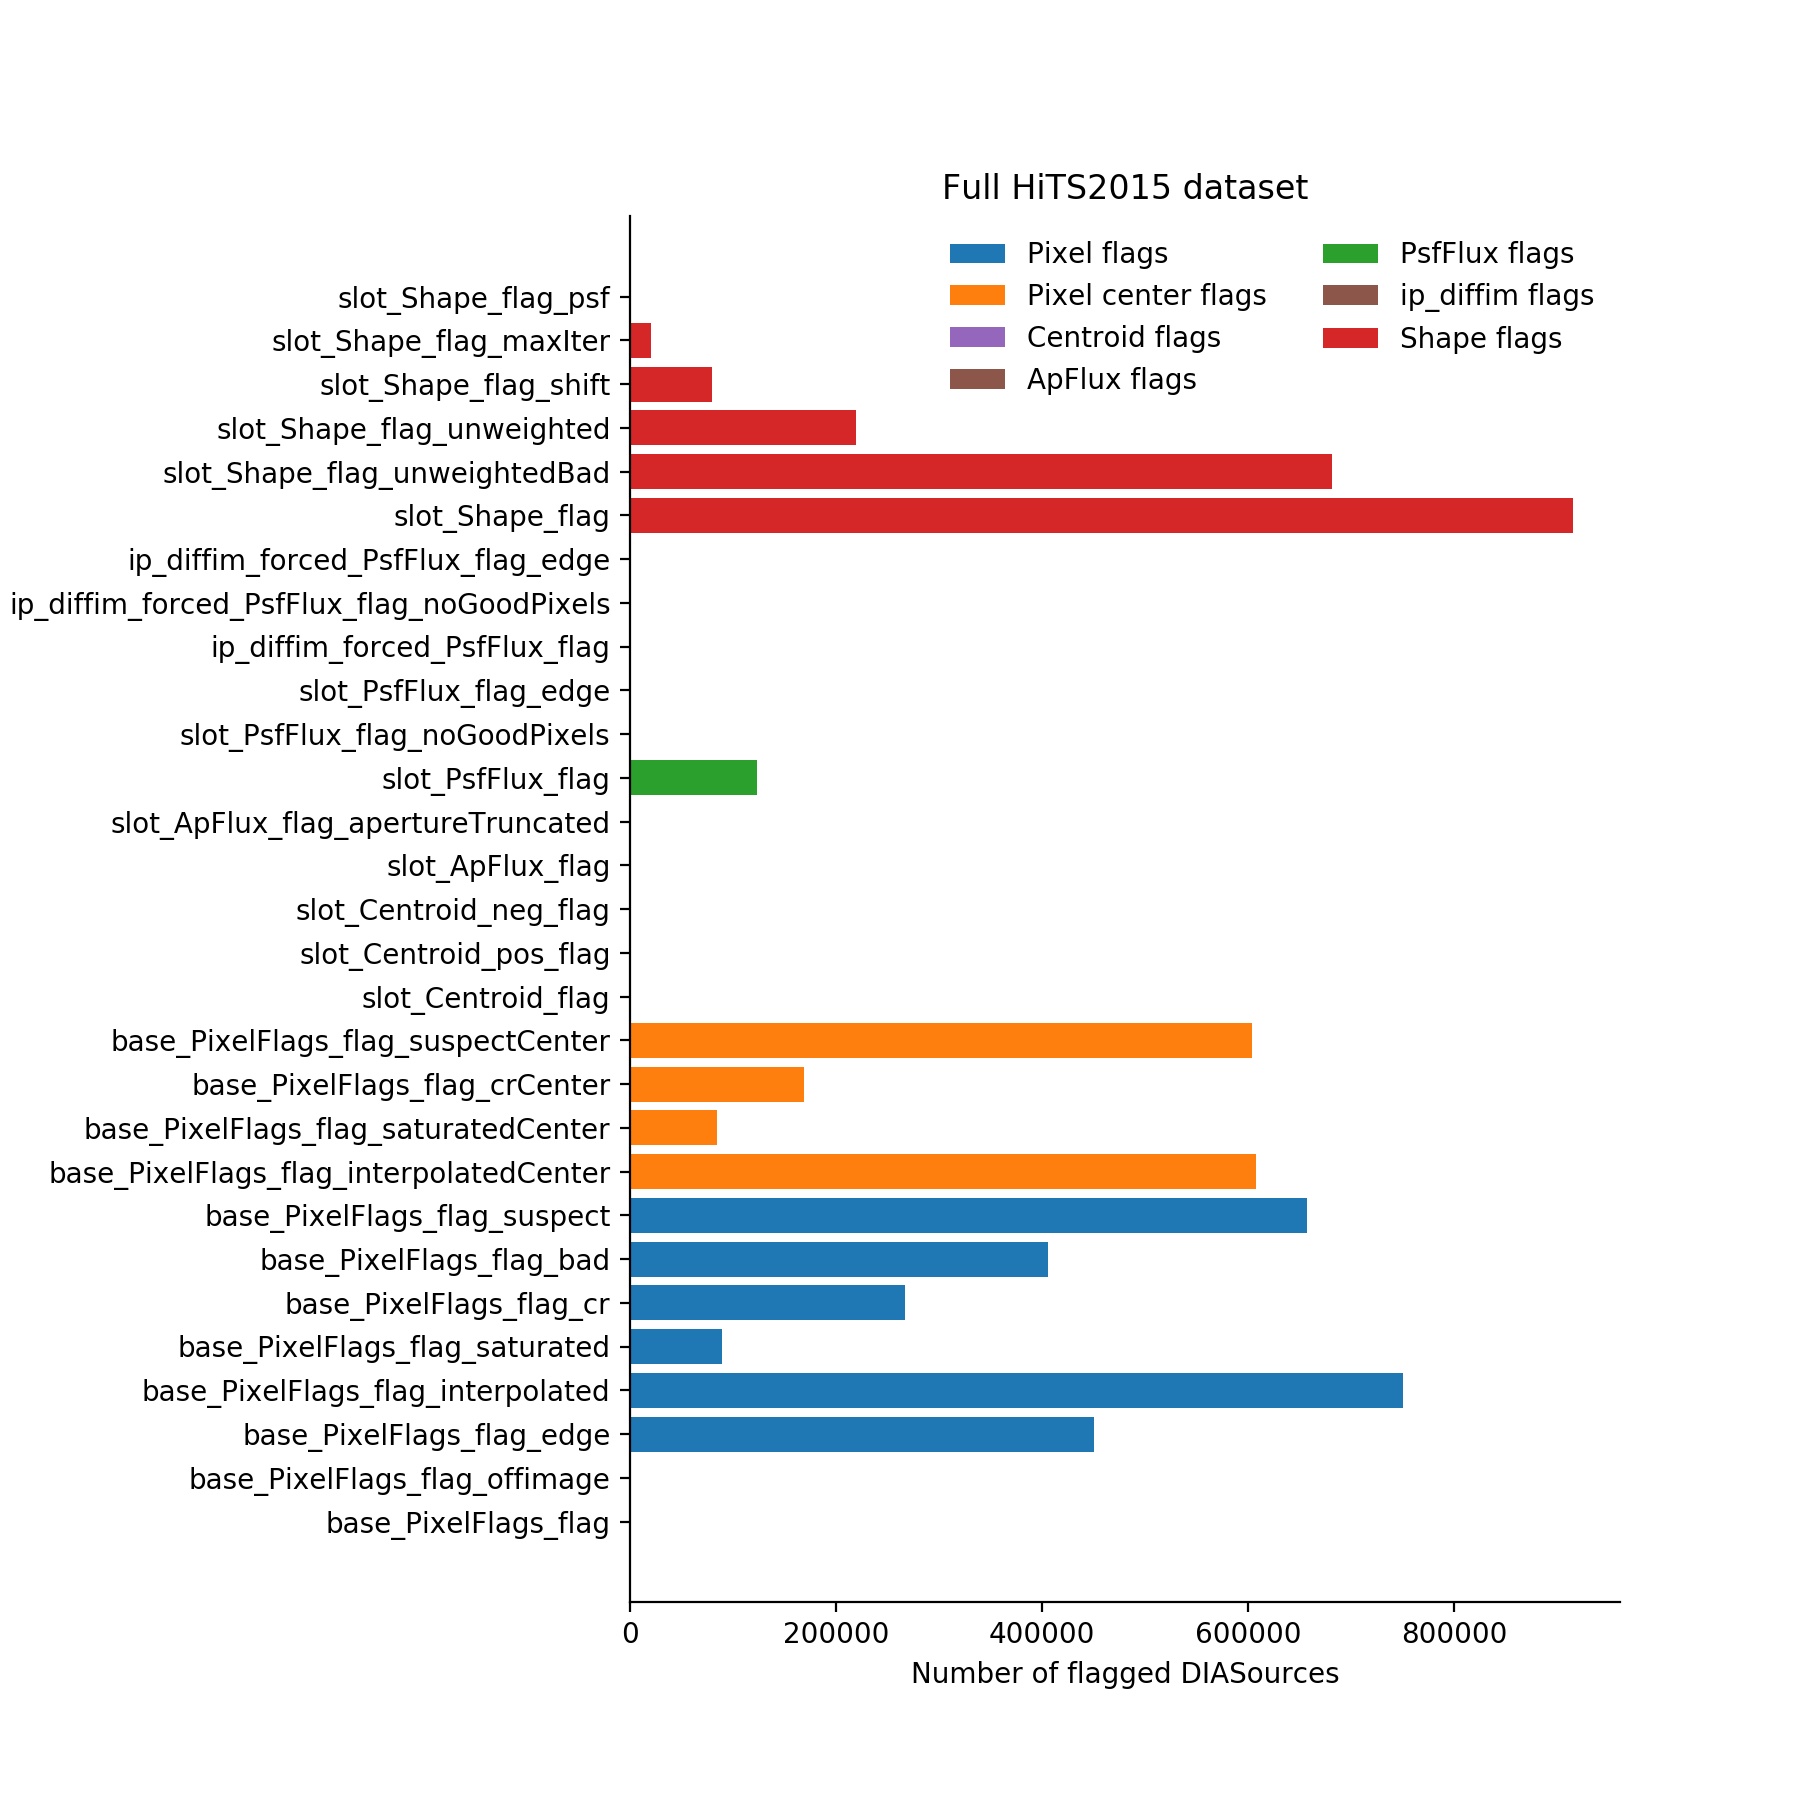

In [66]:
plot_flag_hist([count for count in flagSum.values], flag_names, title='Full HiTS2015 dataset')

In [68]:
srcTableFlags = pd.merge(srcTable, flagTable, left_index=True, right_index=True)

In [90]:
def spatial_flag_plot(df, flagName1, flagName2=None, operator=None, plotFlagged=True, plotUnFlagged=True):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    fig, ax = plt.subplots(figsize=(9,6))
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, 'decl'], 
                    color='C3', s=2, alpha=0.2, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, 'decl'], 
                    color='C0', s=2, alpha=0.2, label=labelFalse)
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.invert_xaxis()
    
    ax.set_xlim(156.5, 155.5)
    ax.set_ylim(-5.85, -5.2)
    
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(bbox_to_anchor=(0.97, 0.9))

<IPython.core.display.Javascript object>


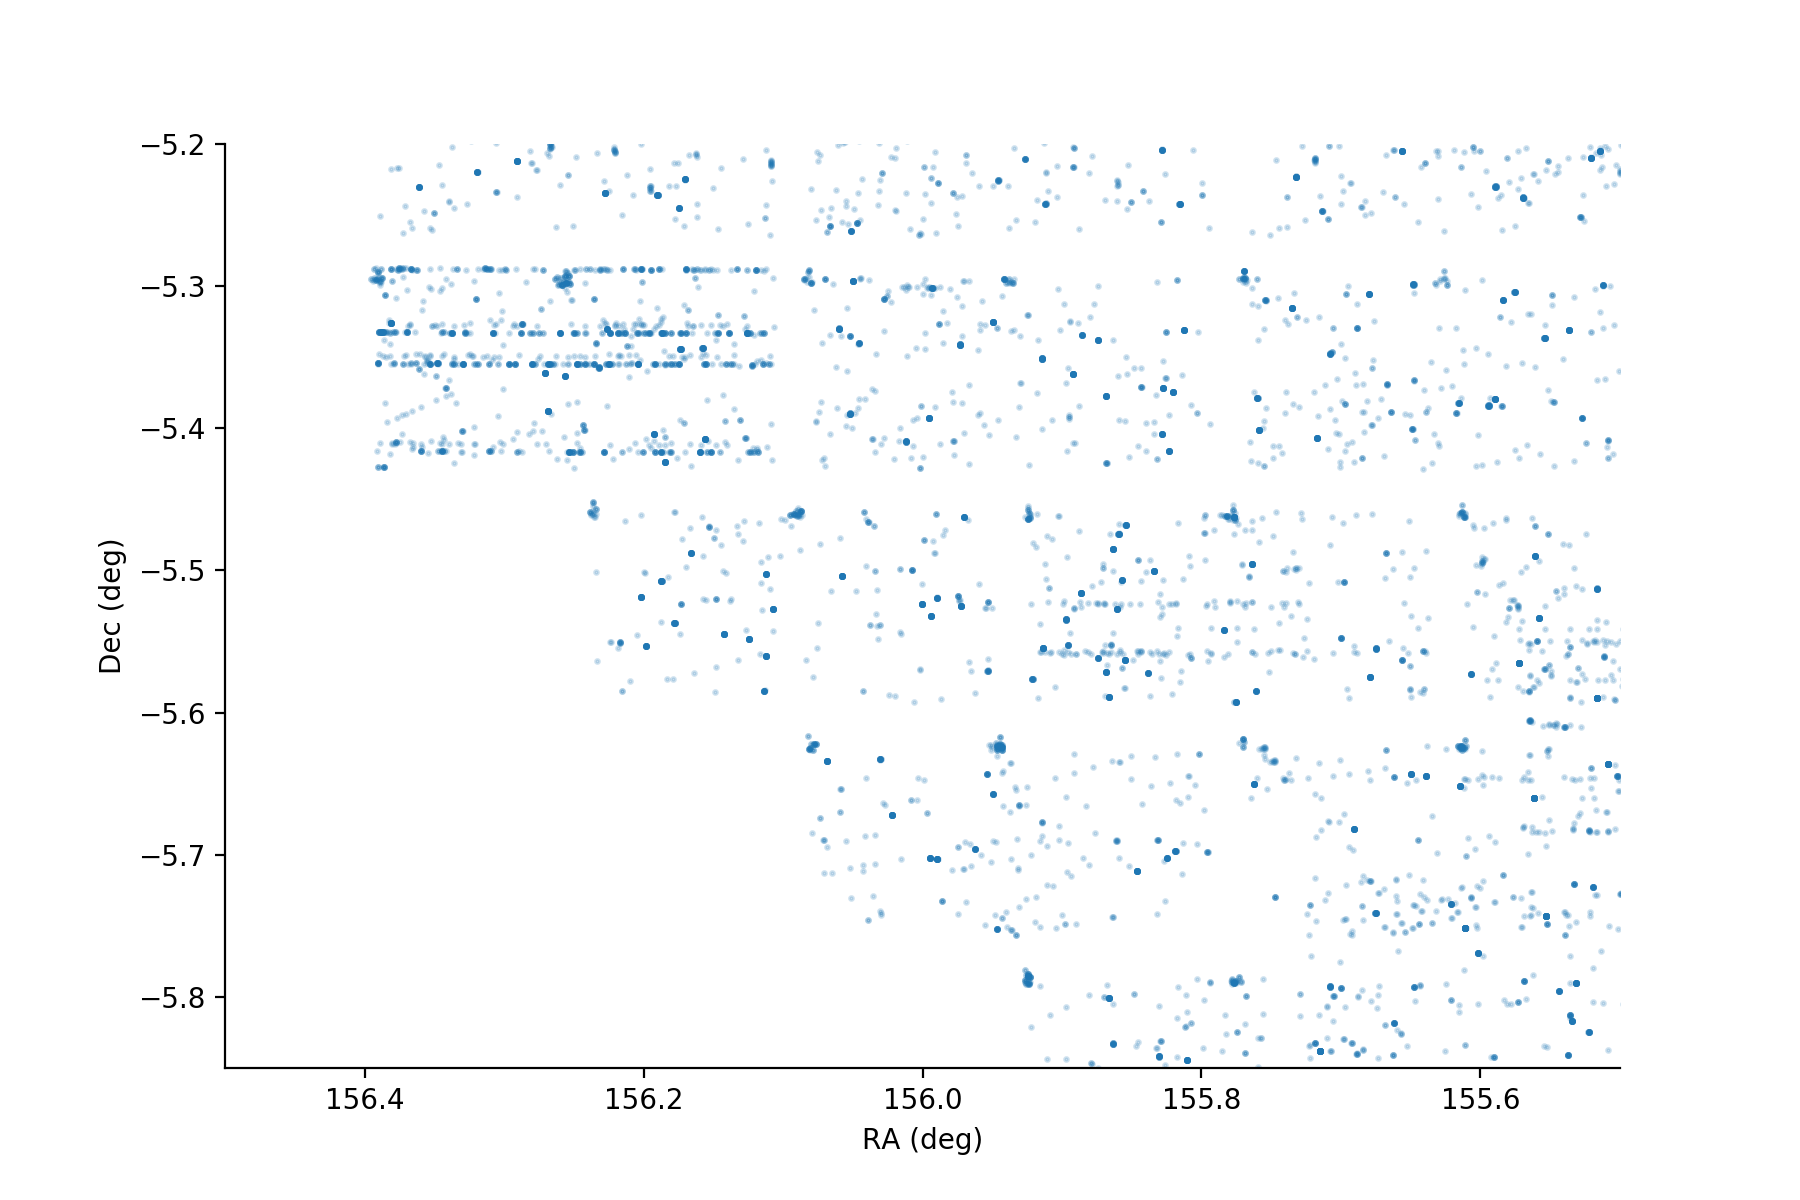

Flagged sources: 1073324
Unflagged sources: 115219


In [91]:
spatial_flag_plot(srcTableFlags, 'slot_Shape_flag', 'base_PixelFlags_flag_suspect', operator='or', plotFlagged=False)

<IPython.core.display.Javascript object>


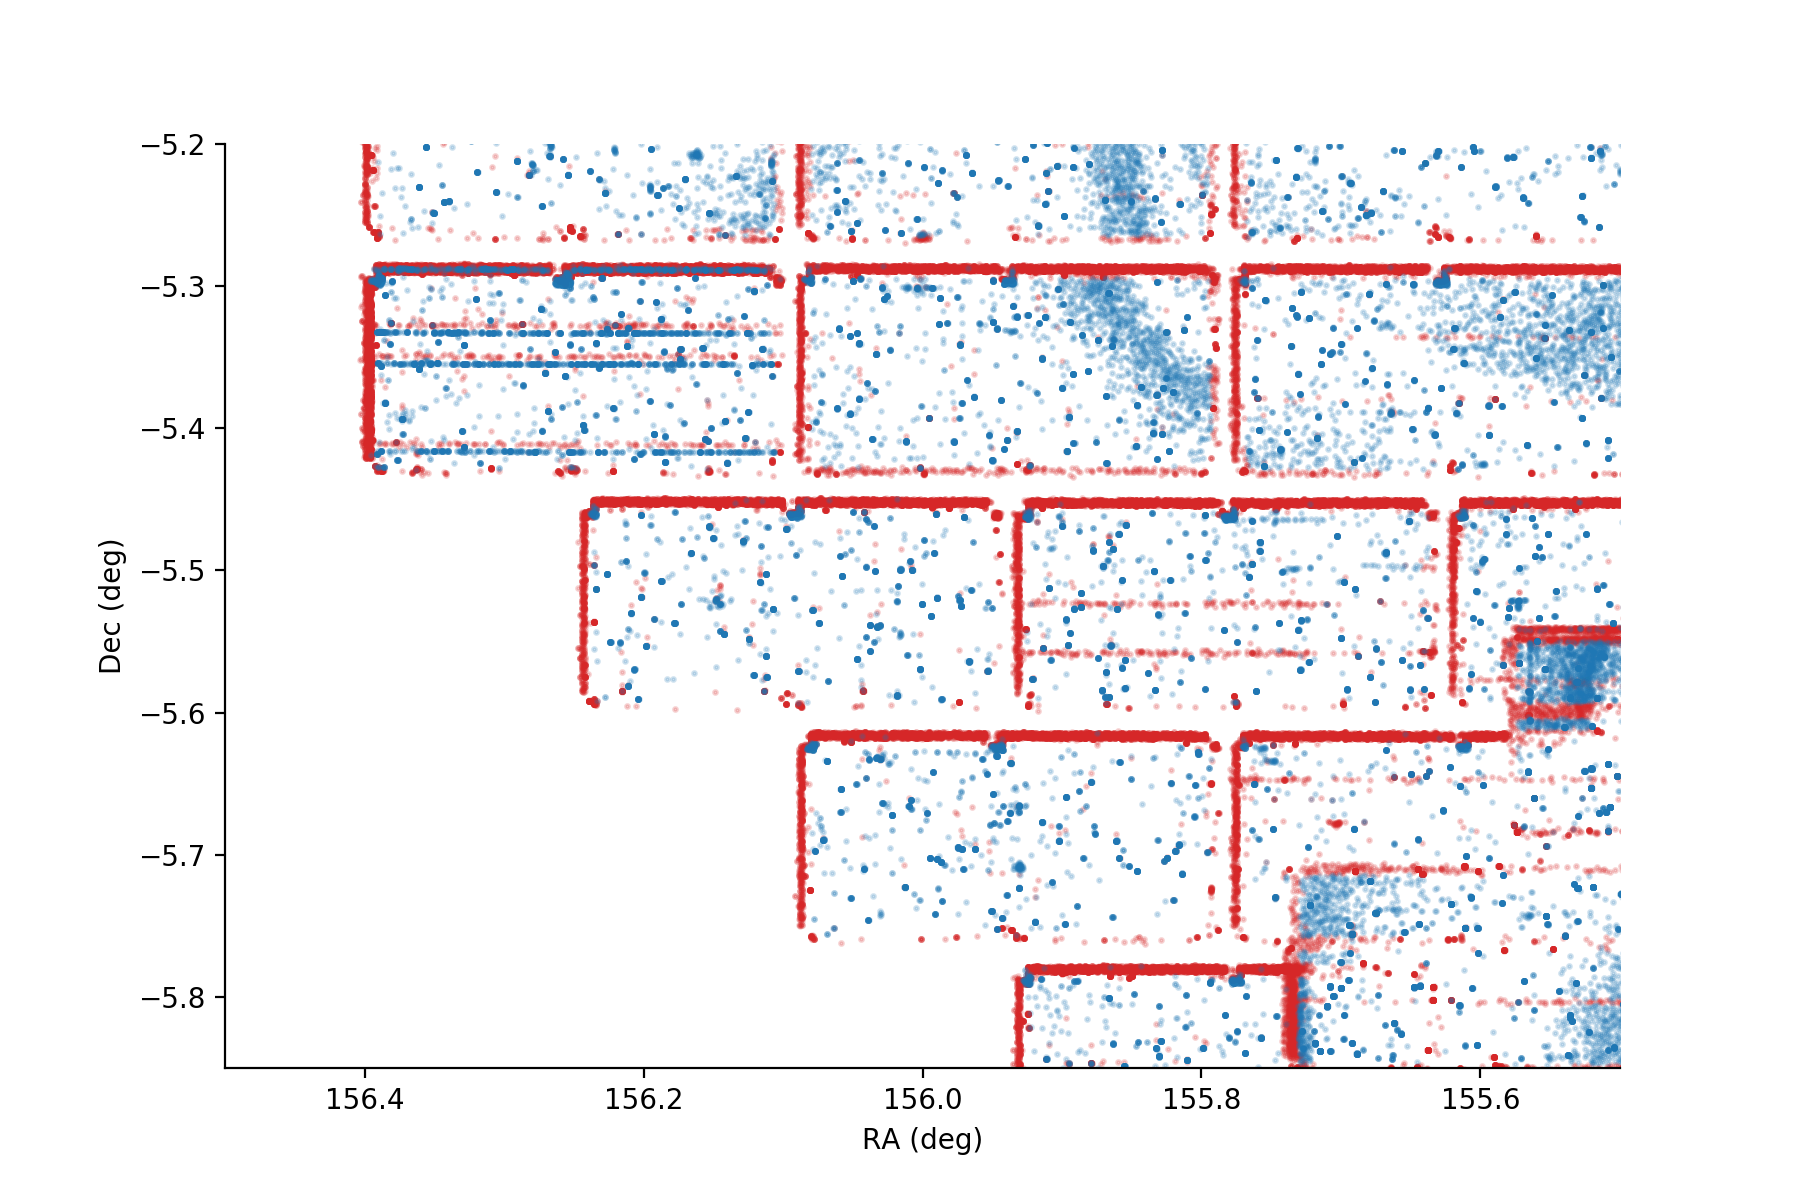

Flagged sources: 730972
Unflagged sources: 457571


In [92]:
spatial_flag_plot(srcTableFlags, 'base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', operator='or')

<IPython.core.display.Javascript object>


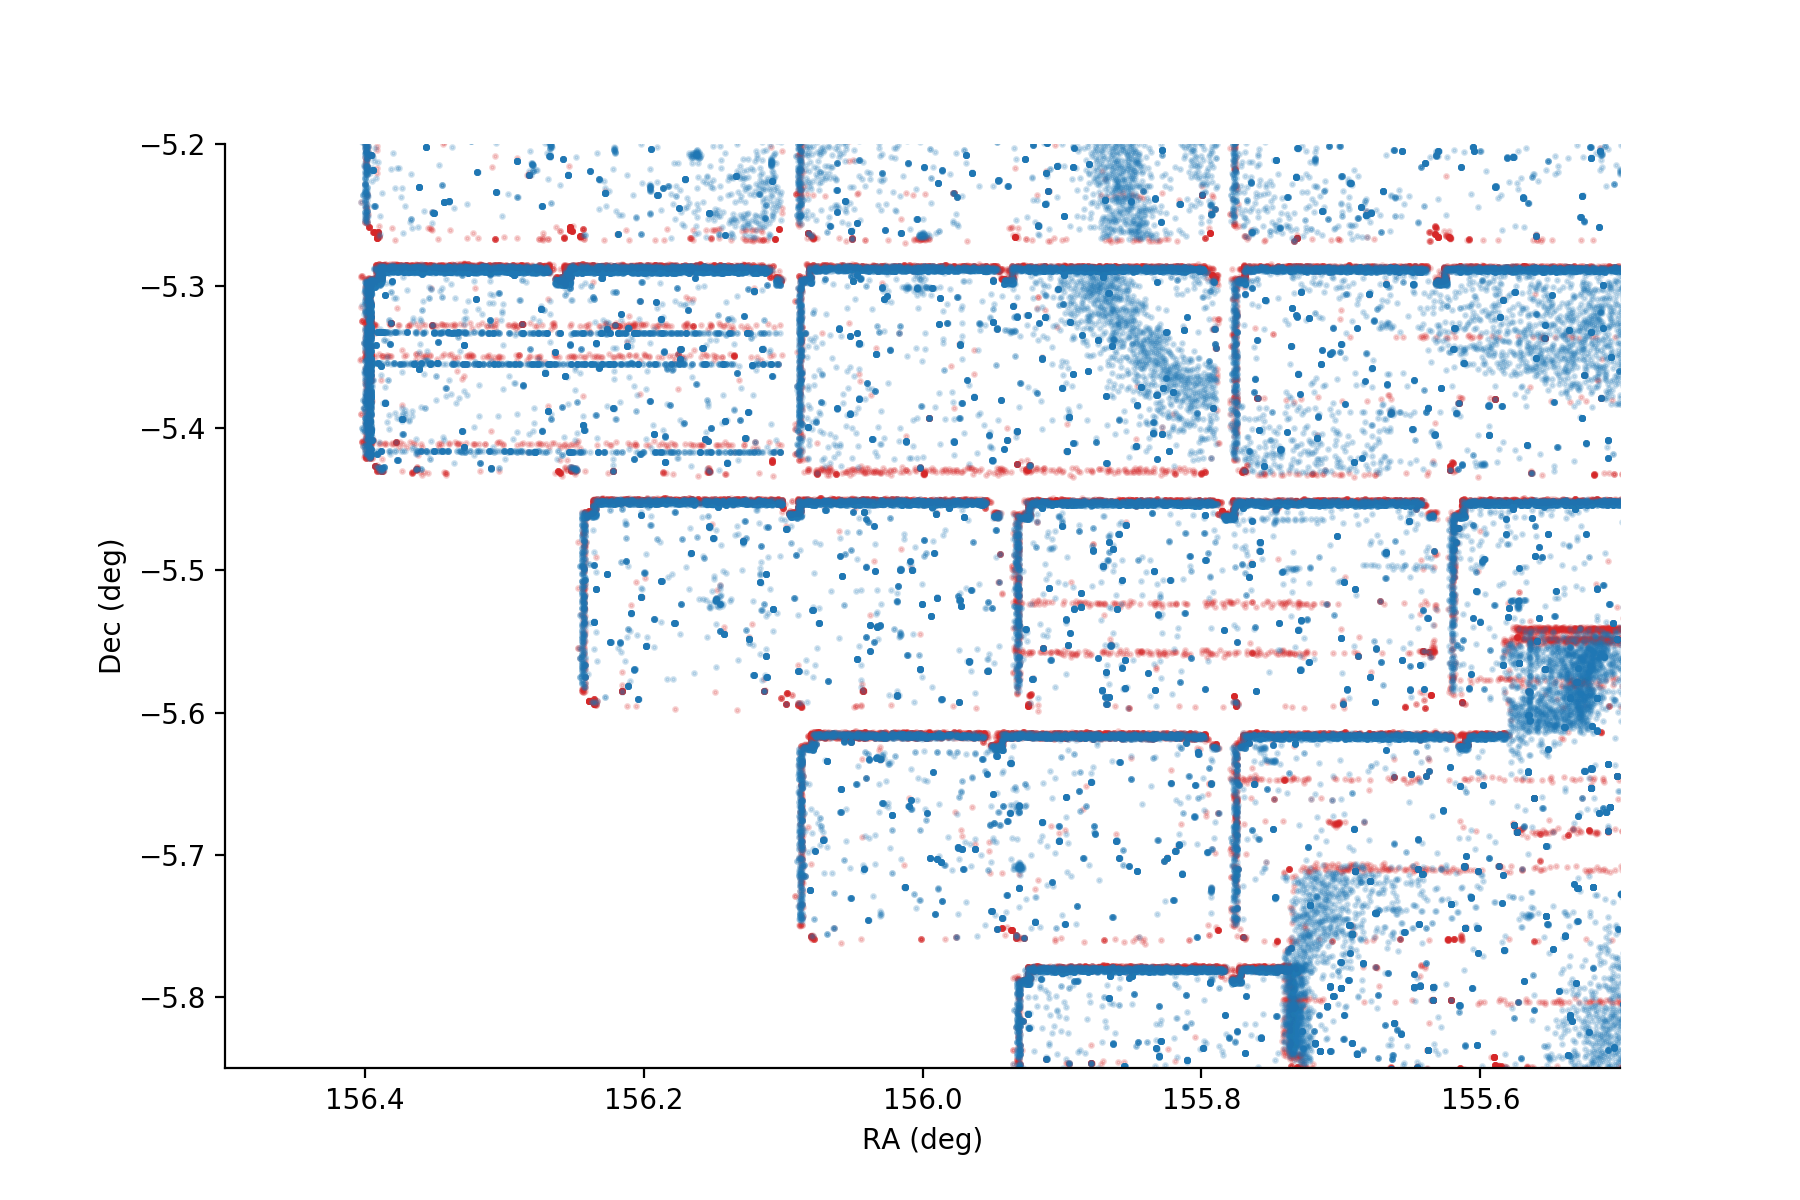

Flagged sources: 406167
Unflagged sources: 782376


In [102]:
spatial_flag_plot(srcTableFlags, 'base_PixelFlags_flag_bad')

There is some weird double-horizontal-line stuff going on in one CCD, but that is a problem for another day.

I think a reasonable combination of flags to use to throw things out is **bad OR suspect OR shape**.

In [213]:
flagFilter = ((srcTableFlags['base_PixelFlags_flag_bad']) | 
              (srcTableFlags['base_PixelFlags_flag_suspect']) |
              (srcTableFlags['slot_Shape_flag'])
             )
flagFilterInverse = ~flagFilter

In [214]:
allObj = set(srcTableFlags['diaObjectId'])

In [215]:
goodObj = set(srcTableFlags.loc[flagFilterInverse, 'diaObjectId'])

In [216]:
print(len(allObj), len(goodObj))

470419 32571


In [217]:
goodObjDf = objTable.loc[objTable['diaObjectId'].isin(goodObj)]

In [218]:
len(goodObjDf)

32571

<IPython.core.display.Javascript object>


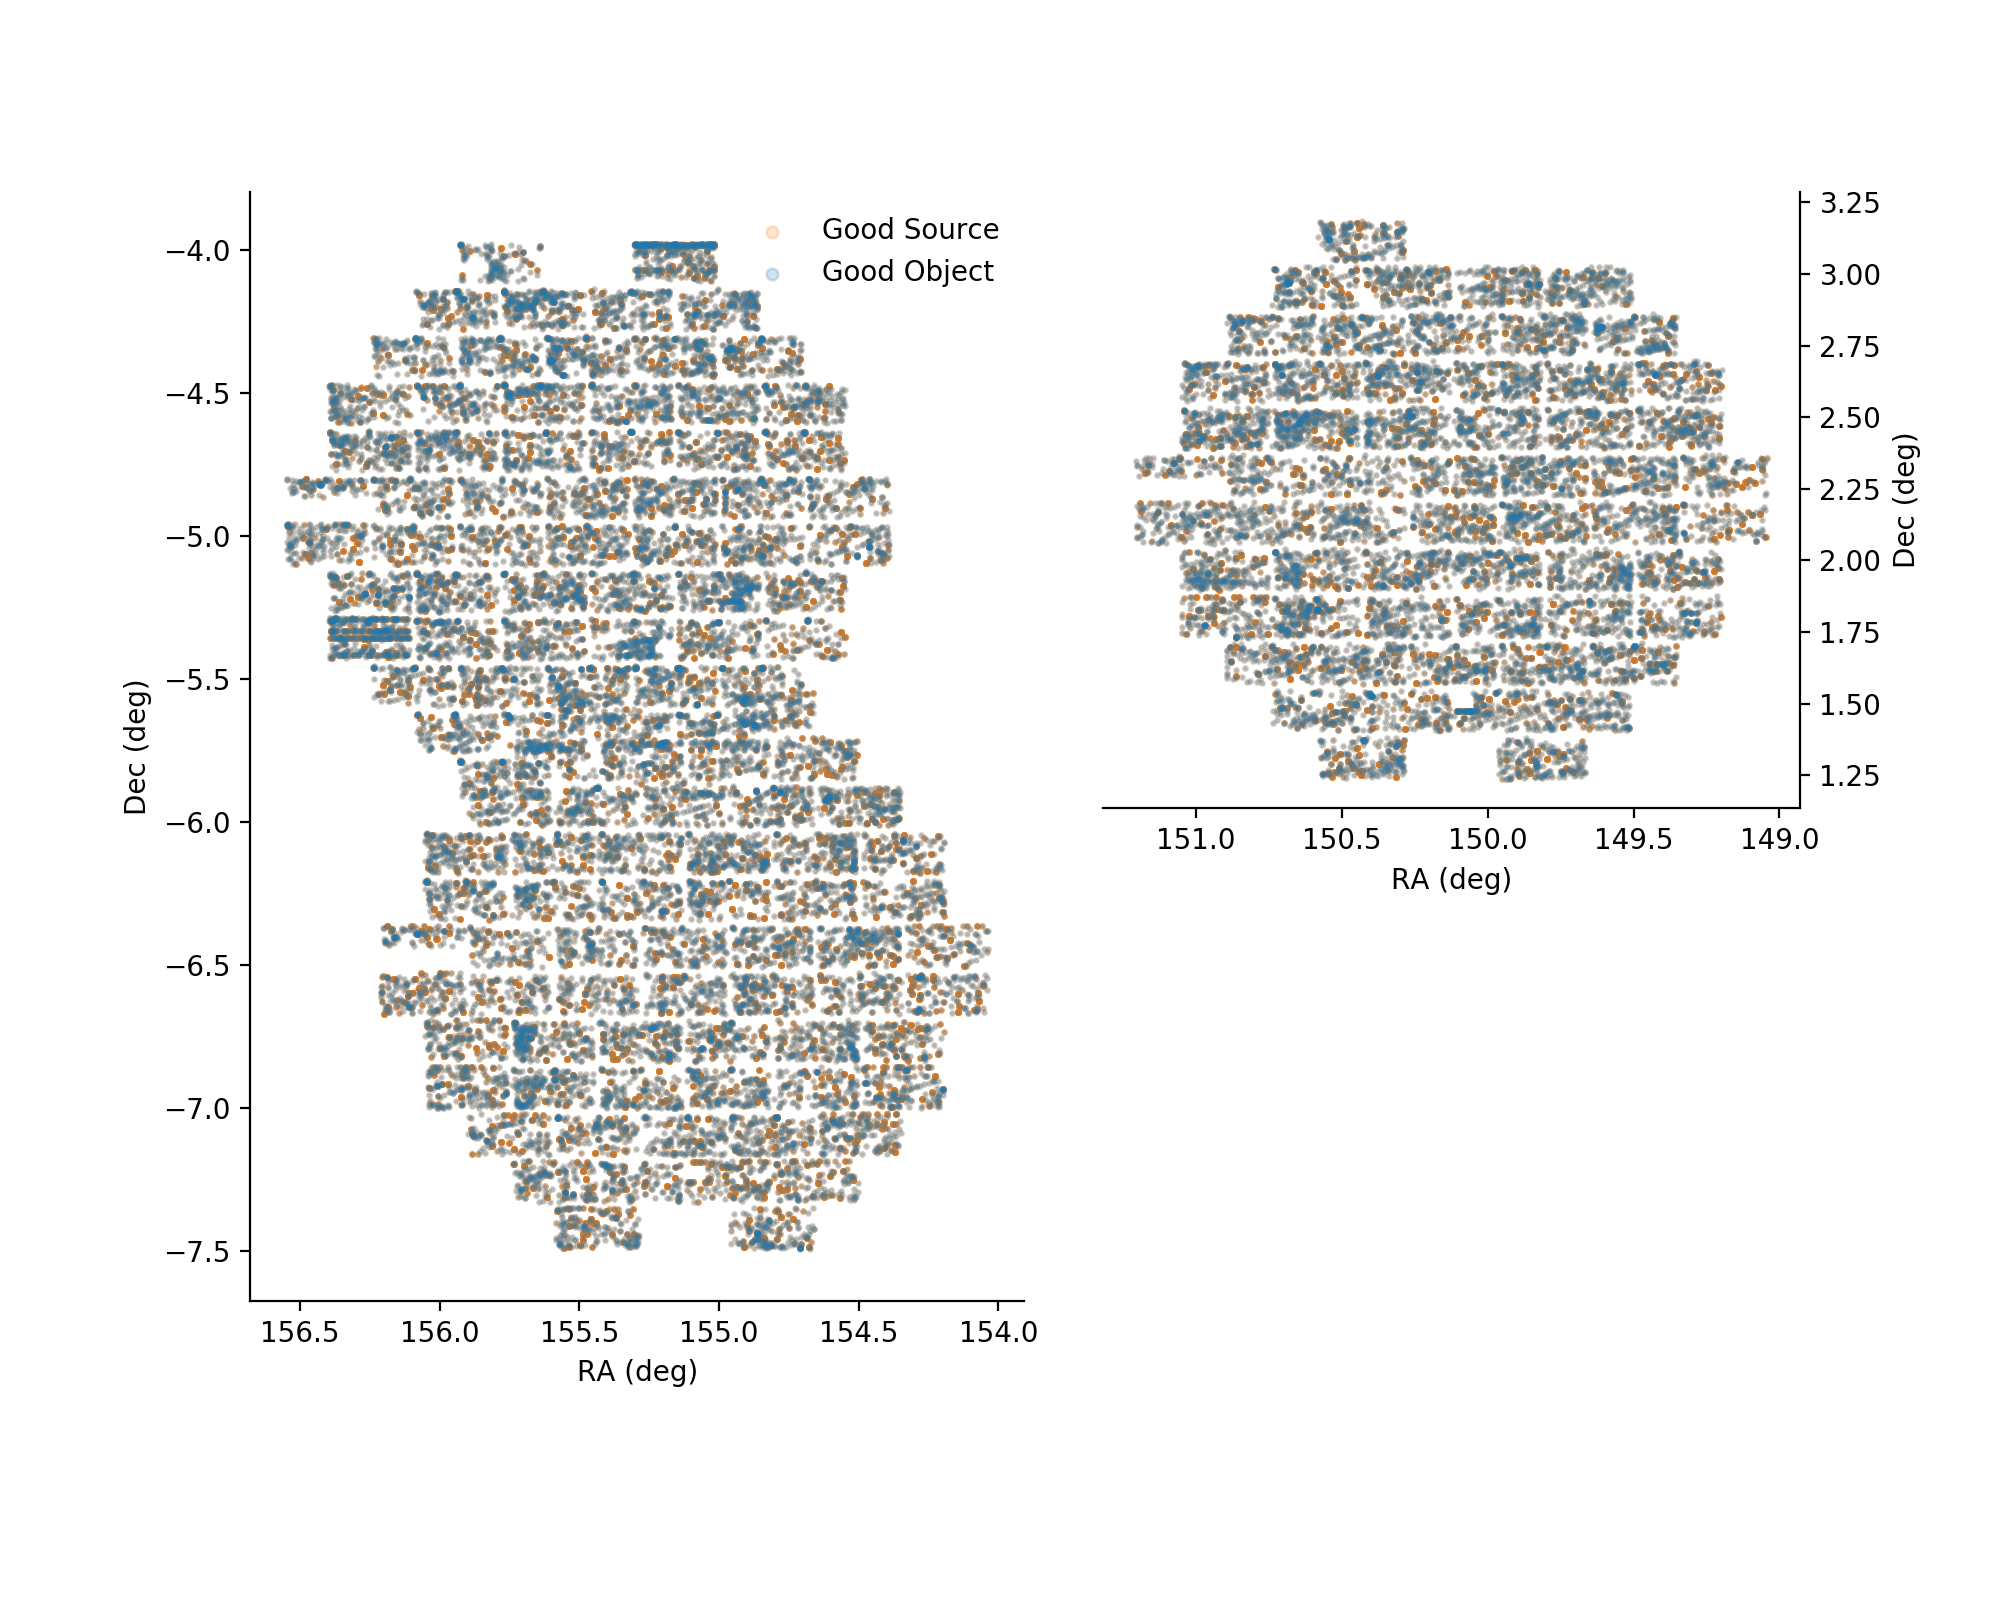

Flagged sources: 1089746
Unflagged sources: 98797
Flagged objects: 437848
Unflagged objects: 32571


In [241]:
plotFlagged = False
plotUnFlagged = True

fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)  # 1 single HiTS field, on the right
ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)  # 2 overlapping HiTS fields, on the left

ax1Filter = (srcTableFlags['decl'] > -2) & flagFilter
ax2Filter = (~ax1Filter) & flagFilter

ax1FilterInverse = (srcTableFlags['decl'] > -2) & flagFilterInverse
ax2FilterInverse = (~ax1FilterInverse) & flagFilterInverse

if plotFlagged:
    scatterFlagged1 = ax1.scatter(srcTableFlags.loc[ax1Filter, 'ra'], 
                                 srcTableFlags.loc[ax1Filter, 'decl'], 
                                 c='C3', s=2, alpha=0.2, label='Bad Source')
    scatterFlagged2 = ax2.scatter(srcTableFlags.loc[ax2Filter, 'ra'], 
                                 srcTableFlags.loc[ax2Filter, 'decl'], 
                                 c='C3', s=2, alpha=0.2, label='Bad Source')
if plotUnFlagged:
    scatterUnflagged1 = ax1.scatter(srcTableFlags.loc[ax1FilterInverse, 'ra'],
                                   srcTableFlags.loc[ax1FilterInverse, 'decl'], 
                                   c='C1', s=2, alpha=0.2, label='Good Source')
    scatterUnflagged2 = ax2.scatter(srcTableFlags.loc[ax2FilterInverse, 'ra'], 
                                   srcTableFlags.loc[ax2FilterInverse, 'decl'], 
                                   c='C1', s=2, alpha=0.2, label='Good Source')
    scatterGoodObj1 = ax1.scatter(goodObjDf.loc[(goodObjDf['decl'] > -2), 'ra'], 
                                  goodObjDf.loc[(goodObjDf['decl'] > -2),'decl'], 
                                  c='C0', s=2, alpha=0.2, label='Good Object')
    scatterGoodObj2 = ax2.scatter(goodObjDf.loc[(goodObjDf['decl'] <= -2), 'ra'], 
                                  goodObjDf.loc[(goodObjDf['decl'] <= -2),'decl'], 
                                  c='C0', s=2, alpha=0.2, label='Good Object')

print('Flagged sources: {0}'.format(len(srcTableFlags.loc[flagFilter, 'ra'])))
print('Unflagged sources: {0}'.format(len(srcTableFlags.loc[flagFilterInverse, 'ra'])))
print('Flagged objects: {0}'.format(len(allObj) - len(goodObj)))
print('Unflagged objects: {0}'.format(len(goodObj)))

ax1.set_xlabel('RA (deg)')
ax2.set_xlabel('RA (deg)')
ax1.set_ylabel('Dec (deg)')
ax2.set_ylabel('Dec (deg)')

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.invert_xaxis()
ax2.invert_xaxis()

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

plt.subplots_adjust(wspace=0.1, hspace=0)

ax2.legend(loc='upper right', frameon=False, markerscale=3)

#ax.set_xlim(156.5, 155.5)
#ax.set_ylim(-5.85, -5.2)

Let's go back to our "mini dataset" from earlier, now that we've had some fun poking around all ~100k maybe-good sources and ~30k maybe-good objects

In [244]:
miniDatasetGoodObj = ((goodObjDf['ra'] > 154.8) & (goodObjDf['ra'] < 155.3) &
                      (goodObjDf['decl'] > -6.02) & (goodObjDf['decl'] < -5.60))  # CI region plus nearby friends

In [245]:
miniDatasetGoodSrc = ((~flagFilter) & (srcTableFlags['ra'] > 154.8) & (srcTableFlags['ra'] < 155.3) &
                      (srcTableFlags['decl'] > -6.02) & (srcTableFlags['decl'] < -5.60))

In [246]:
miniGoodObjDf = goodObjDf.loc[miniDatasetGoodObj]
miniGoodSrcDf = srcTableFlags.loc[miniDatasetGoodSrc]

In [247]:
print(len(miniGoodObjDf), len(miniGoodSrcDf))

818 2538


One final filter: only look at objects with several sources

In [264]:
miniGoodObjDfMult = miniGoodObjDf.loc[miniGoodObjDf['nDiaSources'] >= 20]

In [265]:
len(miniGoodObjDfMult)

138

<IPython.core.display.Javascript object>


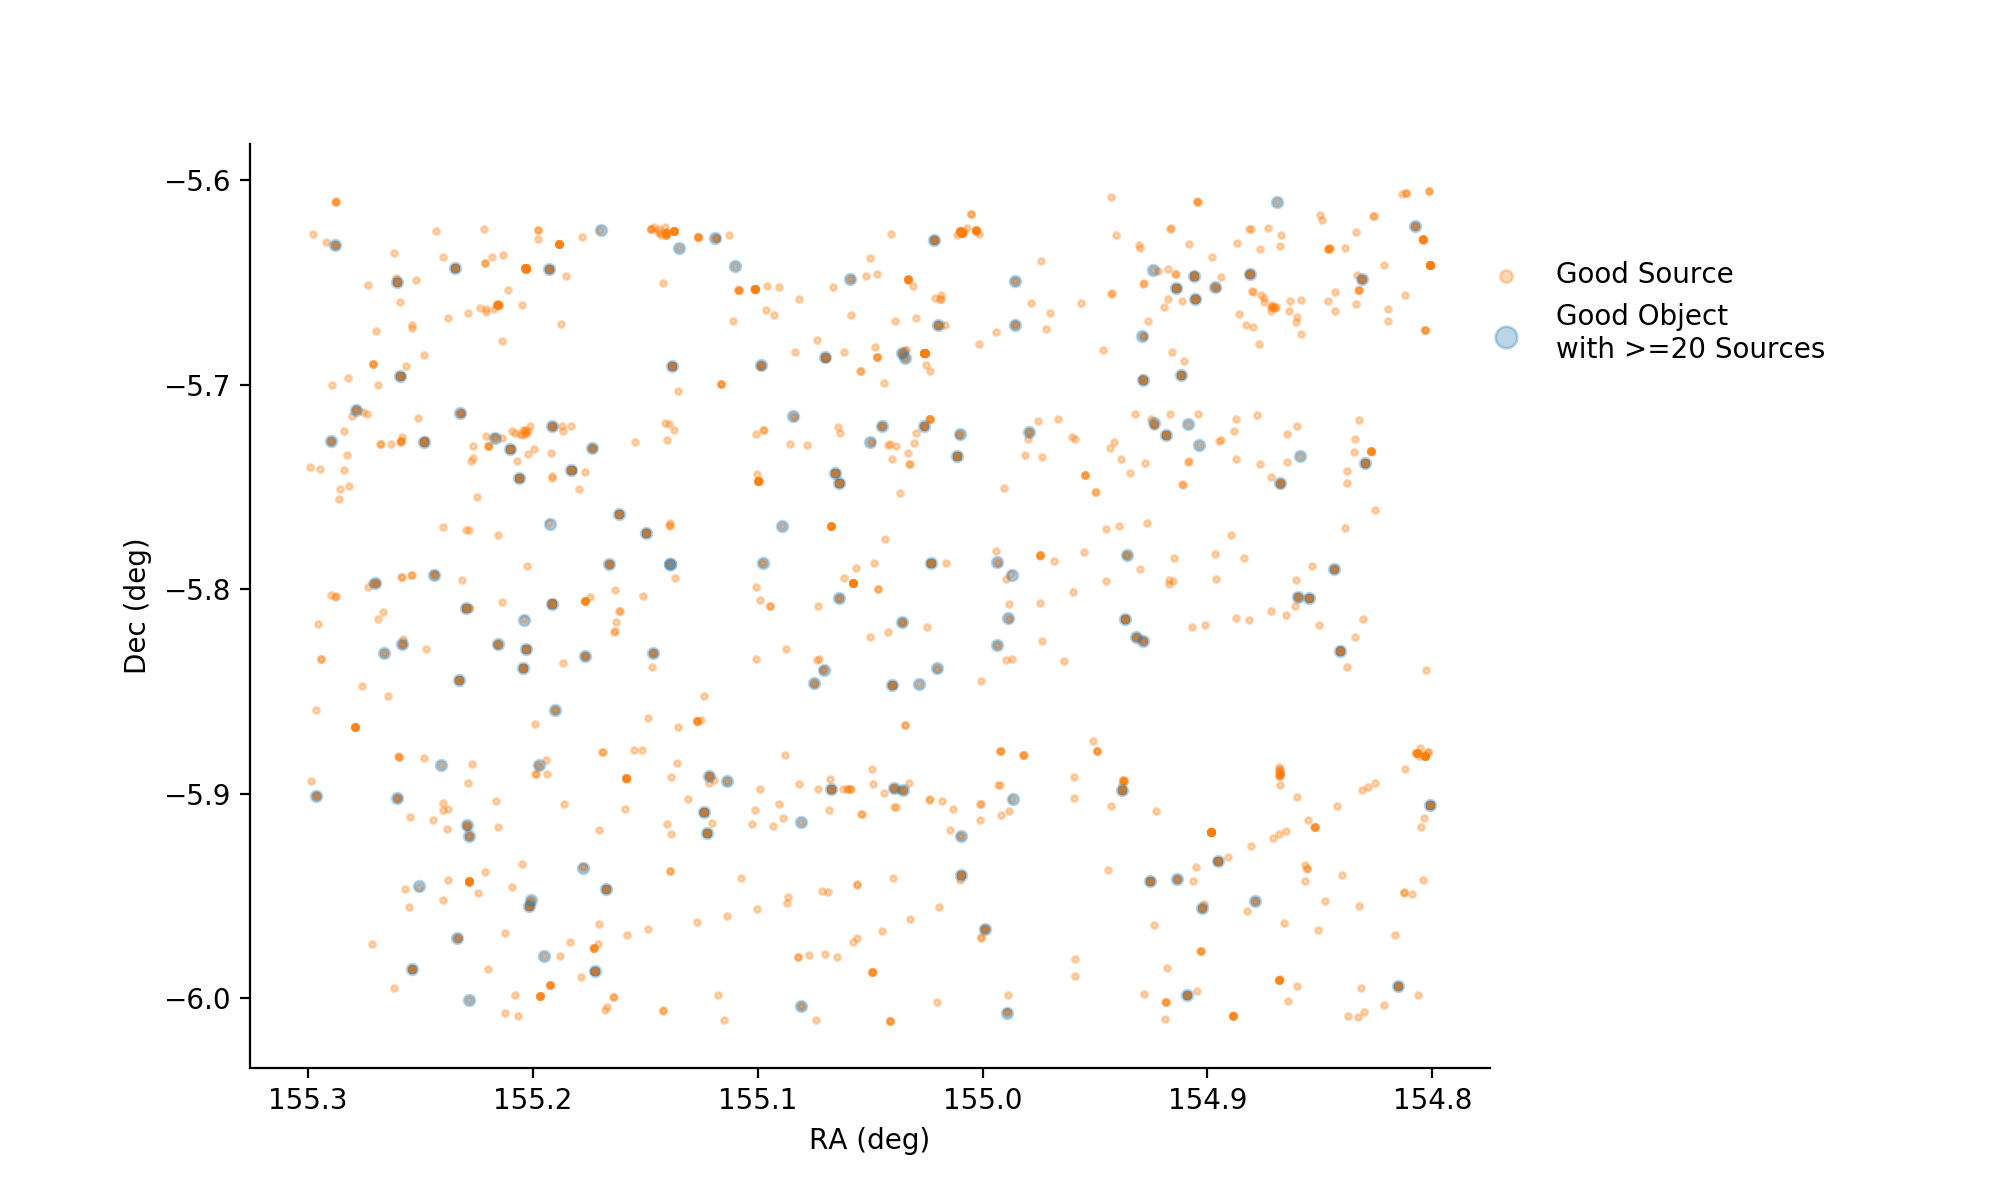

In [288]:
plotFlagged = True
plotUnFlagged = True

flagFilter = ((miniGoodSrcDf['base_PixelFlags_flag_bad']) | 
              (miniGoodSrcDf['base_PixelFlags_flag_suspect']) |
              (miniGoodSrcDf['slot_Shape_flag'])
             )
flagFilterInverse = ~flagFilter

fig, ax2 = plt.subplots(figsize=(10,6))

#ax1Filter = (miniGoodSrcDf['decl'] > -2) & flagFilter
#ax2Filter = (~ax1Filter) & flagFilter

ax1FilterInverse = (srcTableFlags['decl'] > -2) & flagFilterInverse
ax2FilterInverse = (~ax1FilterInverse) & flagFilterInverse

scatterUnflagged2 = ax2.scatter(miniGoodSrcDf['ra'], 
                                miniGoodSrcDf['decl'], 
                                c='C1', s=5, alpha=0.3, label='Good Source')
scatterGoodObj2 = ax2.scatter(miniGoodObjDf.loc[(miniGoodObjDf['nDiaSources'] >= 20), 'ra'], 
                              miniGoodObjDf.loc[(miniGoodObjDf['nDiaSources'] >= 20),'decl'], 
                              c='C0', s=15, alpha=0.3, label='Good Object \nwith >=20 Sources')

ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.invert_xaxis()

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.legend(bbox_to_anchor=(0.97, 0.9), frameon=False, markerscale=2)

OK so what do some of these definitely 100% good and not awful for any reason objects look like IRL?

In [267]:
patchList = ['10,8', '11,8', '12,8', '13,8',
             '10,7', '11,7', '12,7', '13,7',
             '10,9', '11,9', '12,9', '13,9',
             '10,5', '11,5', '12,5', '13,5',
             '10,6', '11,6', '12,6', '13,6',
             '10,10', '11,10', '12,10', '13,10']

Loading PPDB Sources...
DIAObject ID: 176492704547471520
RA (deg): [154.9890243]
Dec (deg): [-6.00699829]
Number of DIASources: 24
Template patch: 11,7


<IPython.core.display.Javascript object>


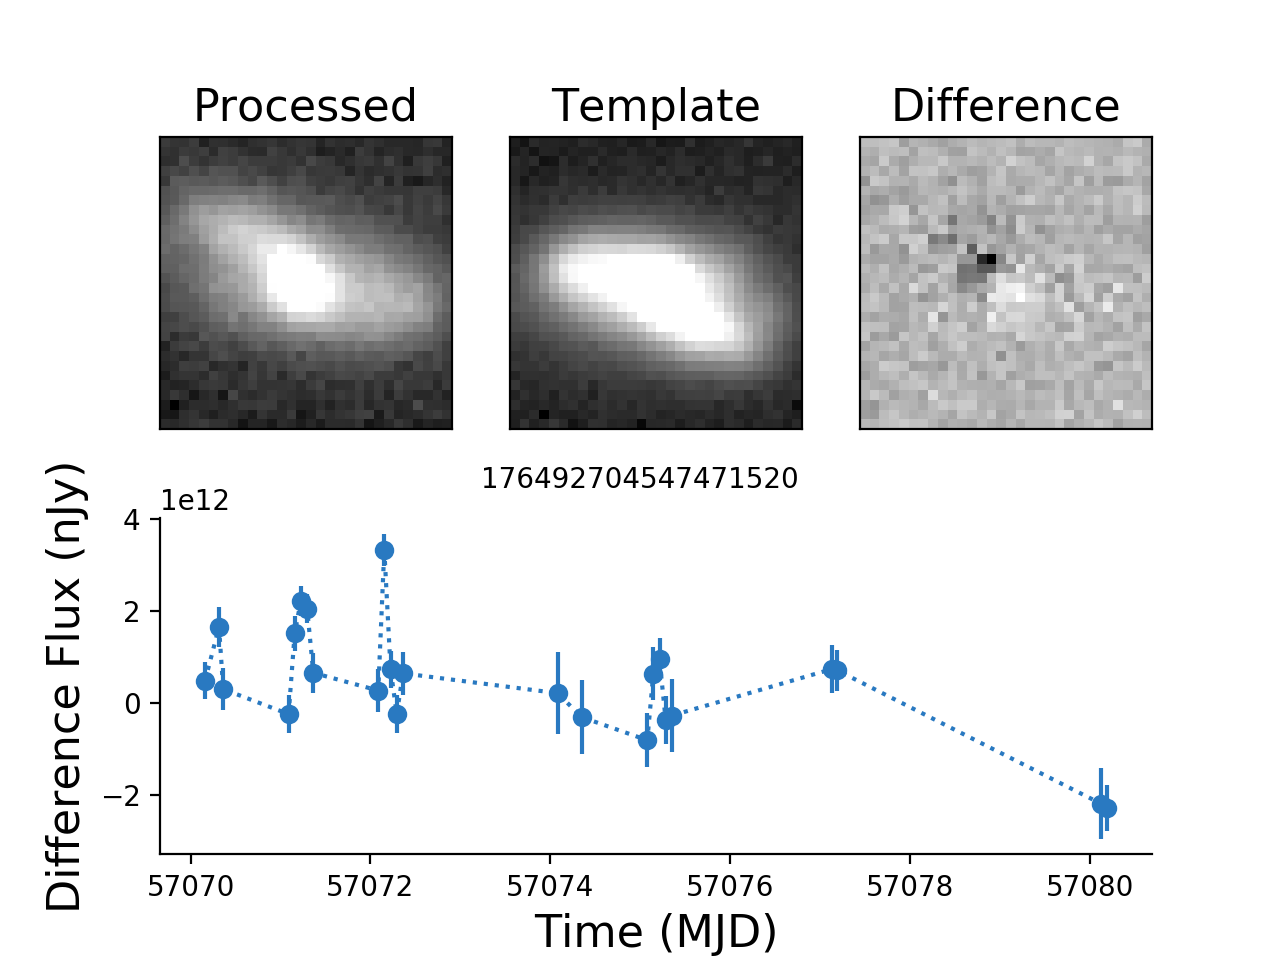

<IPython.core.display.Javascript object>


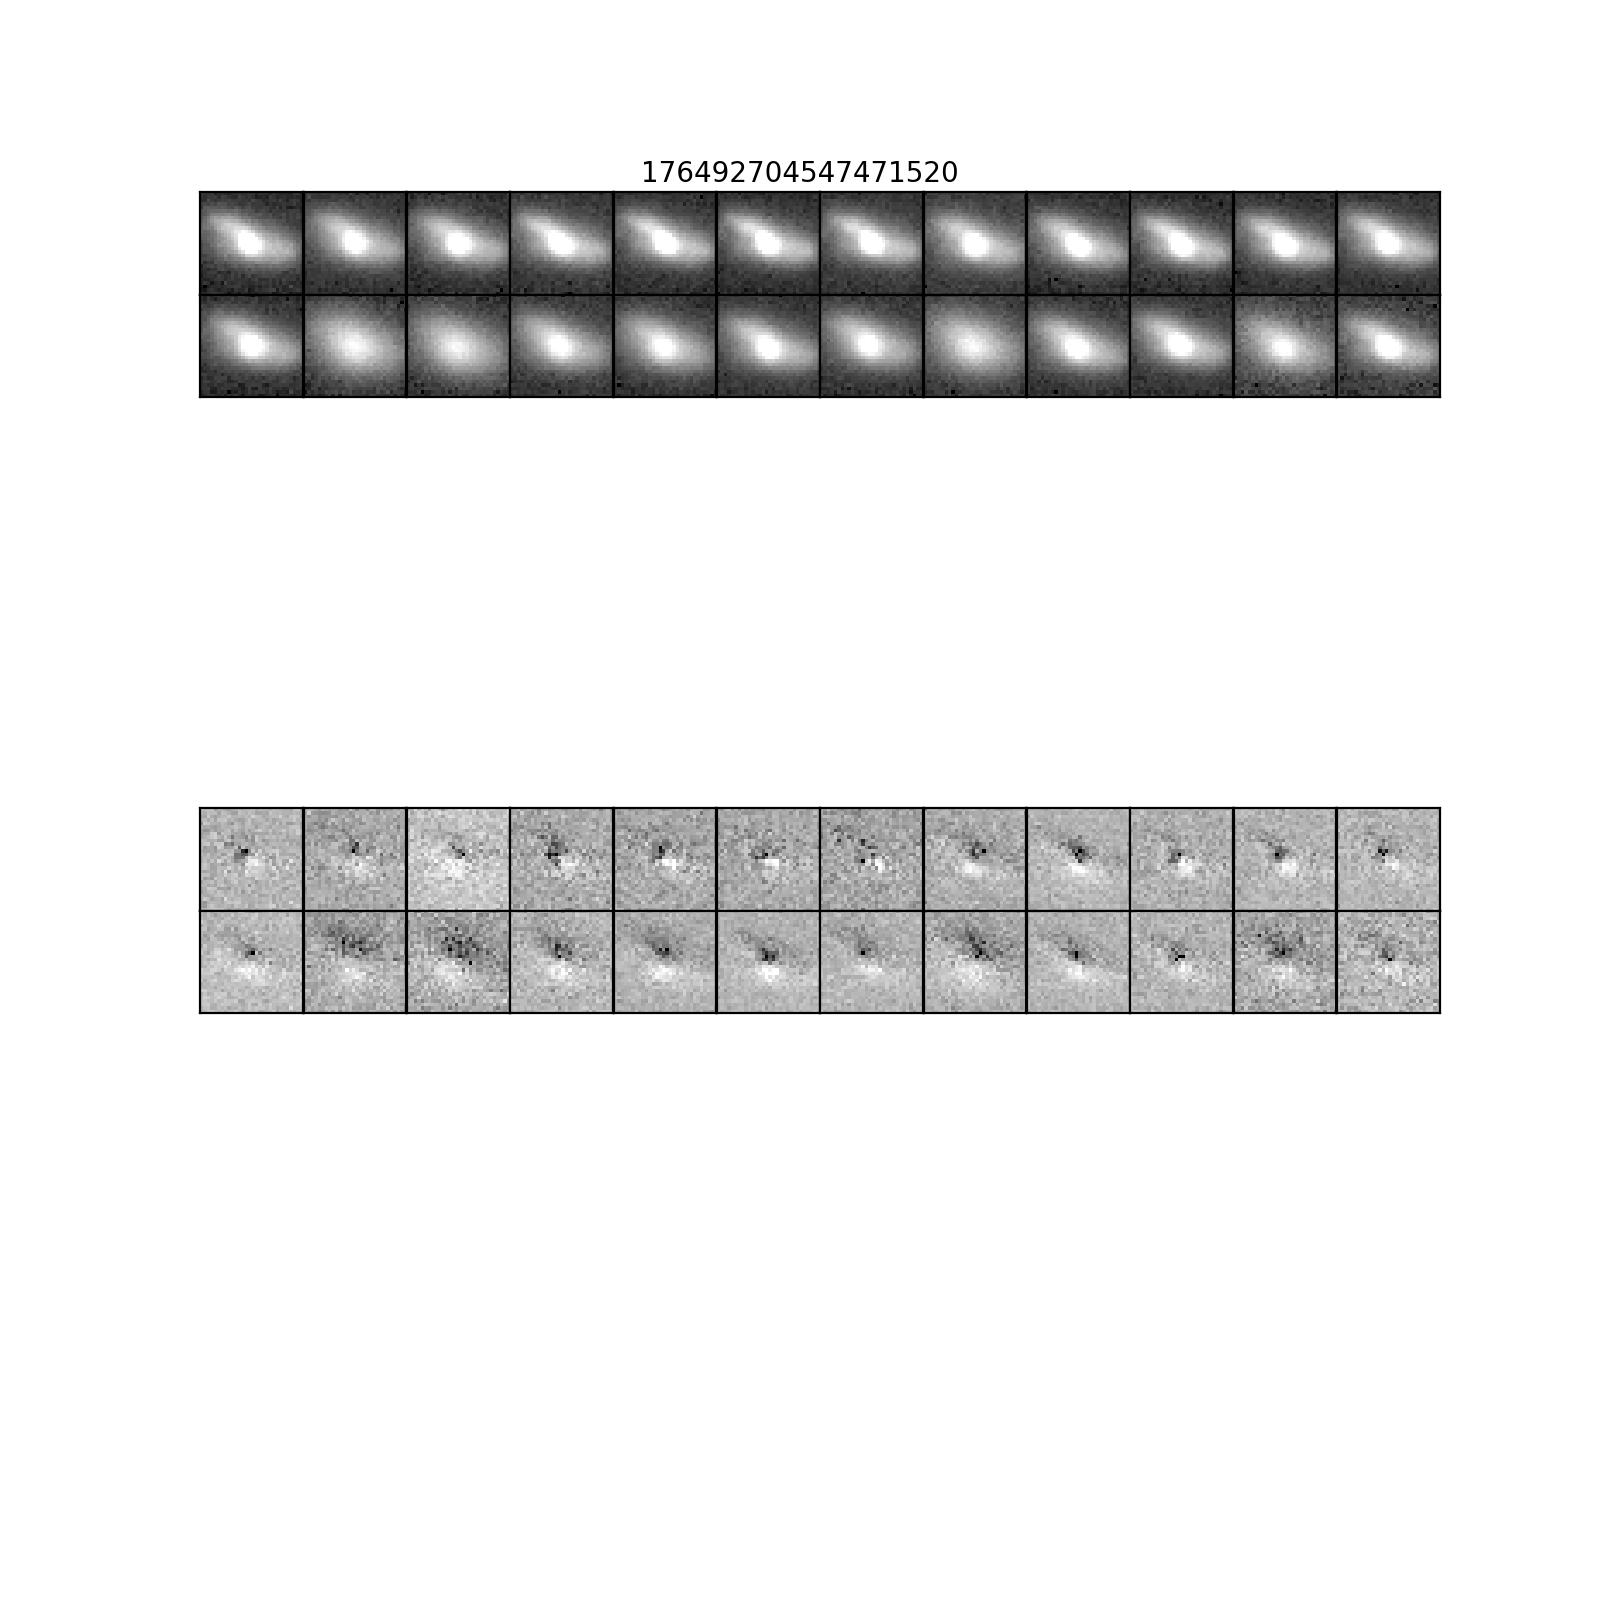

Loading PPDB Sources...
DIAObject ID: 176492704547471582
RA (deg): [155.1776326]
Dec (deg): [-5.93606994]
Number of DIASources: 21
Template patch: 11,7


<IPython.core.display.Javascript object>


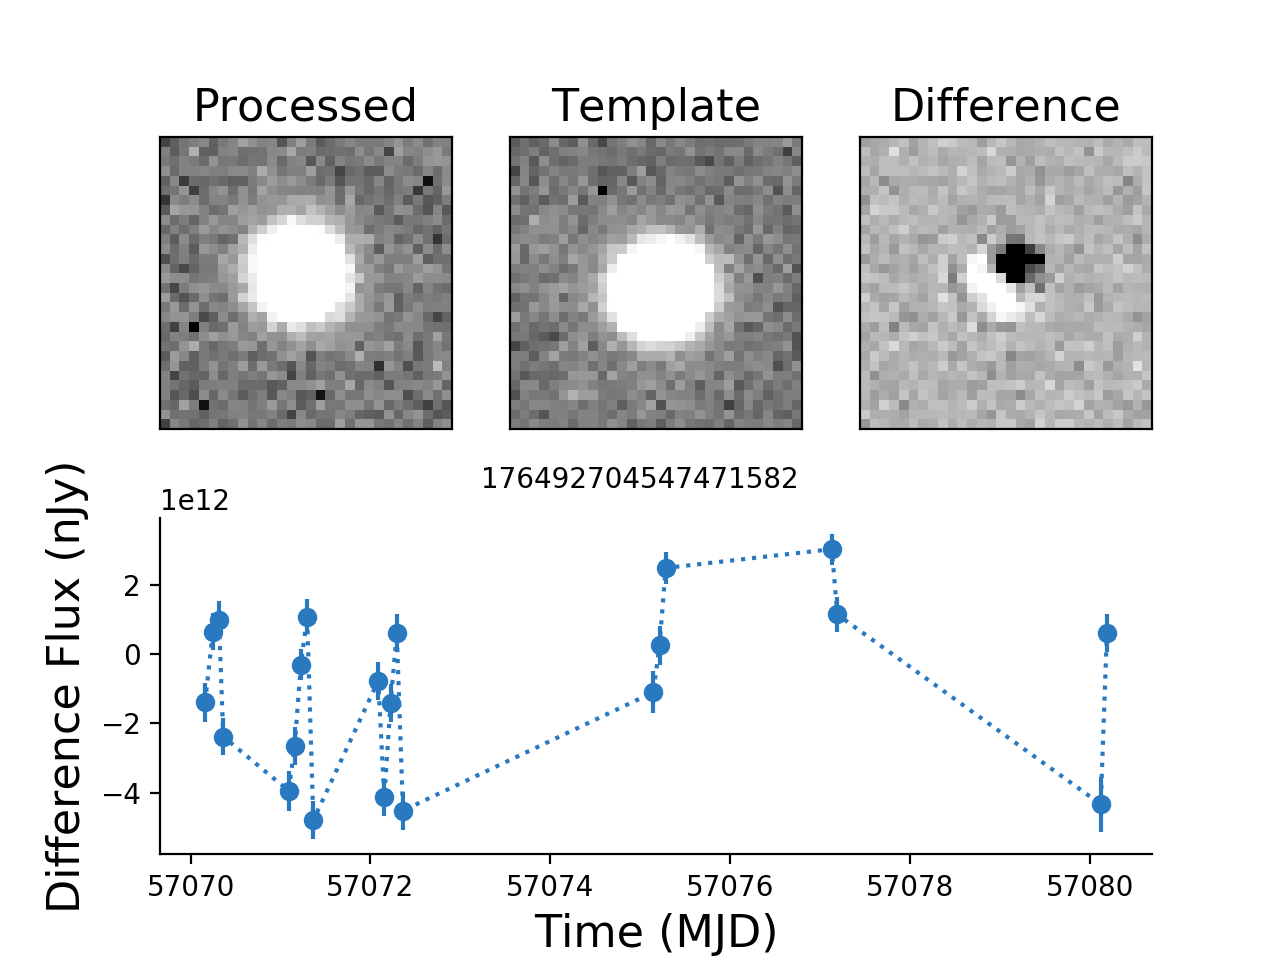

<IPython.core.display.Javascript object>


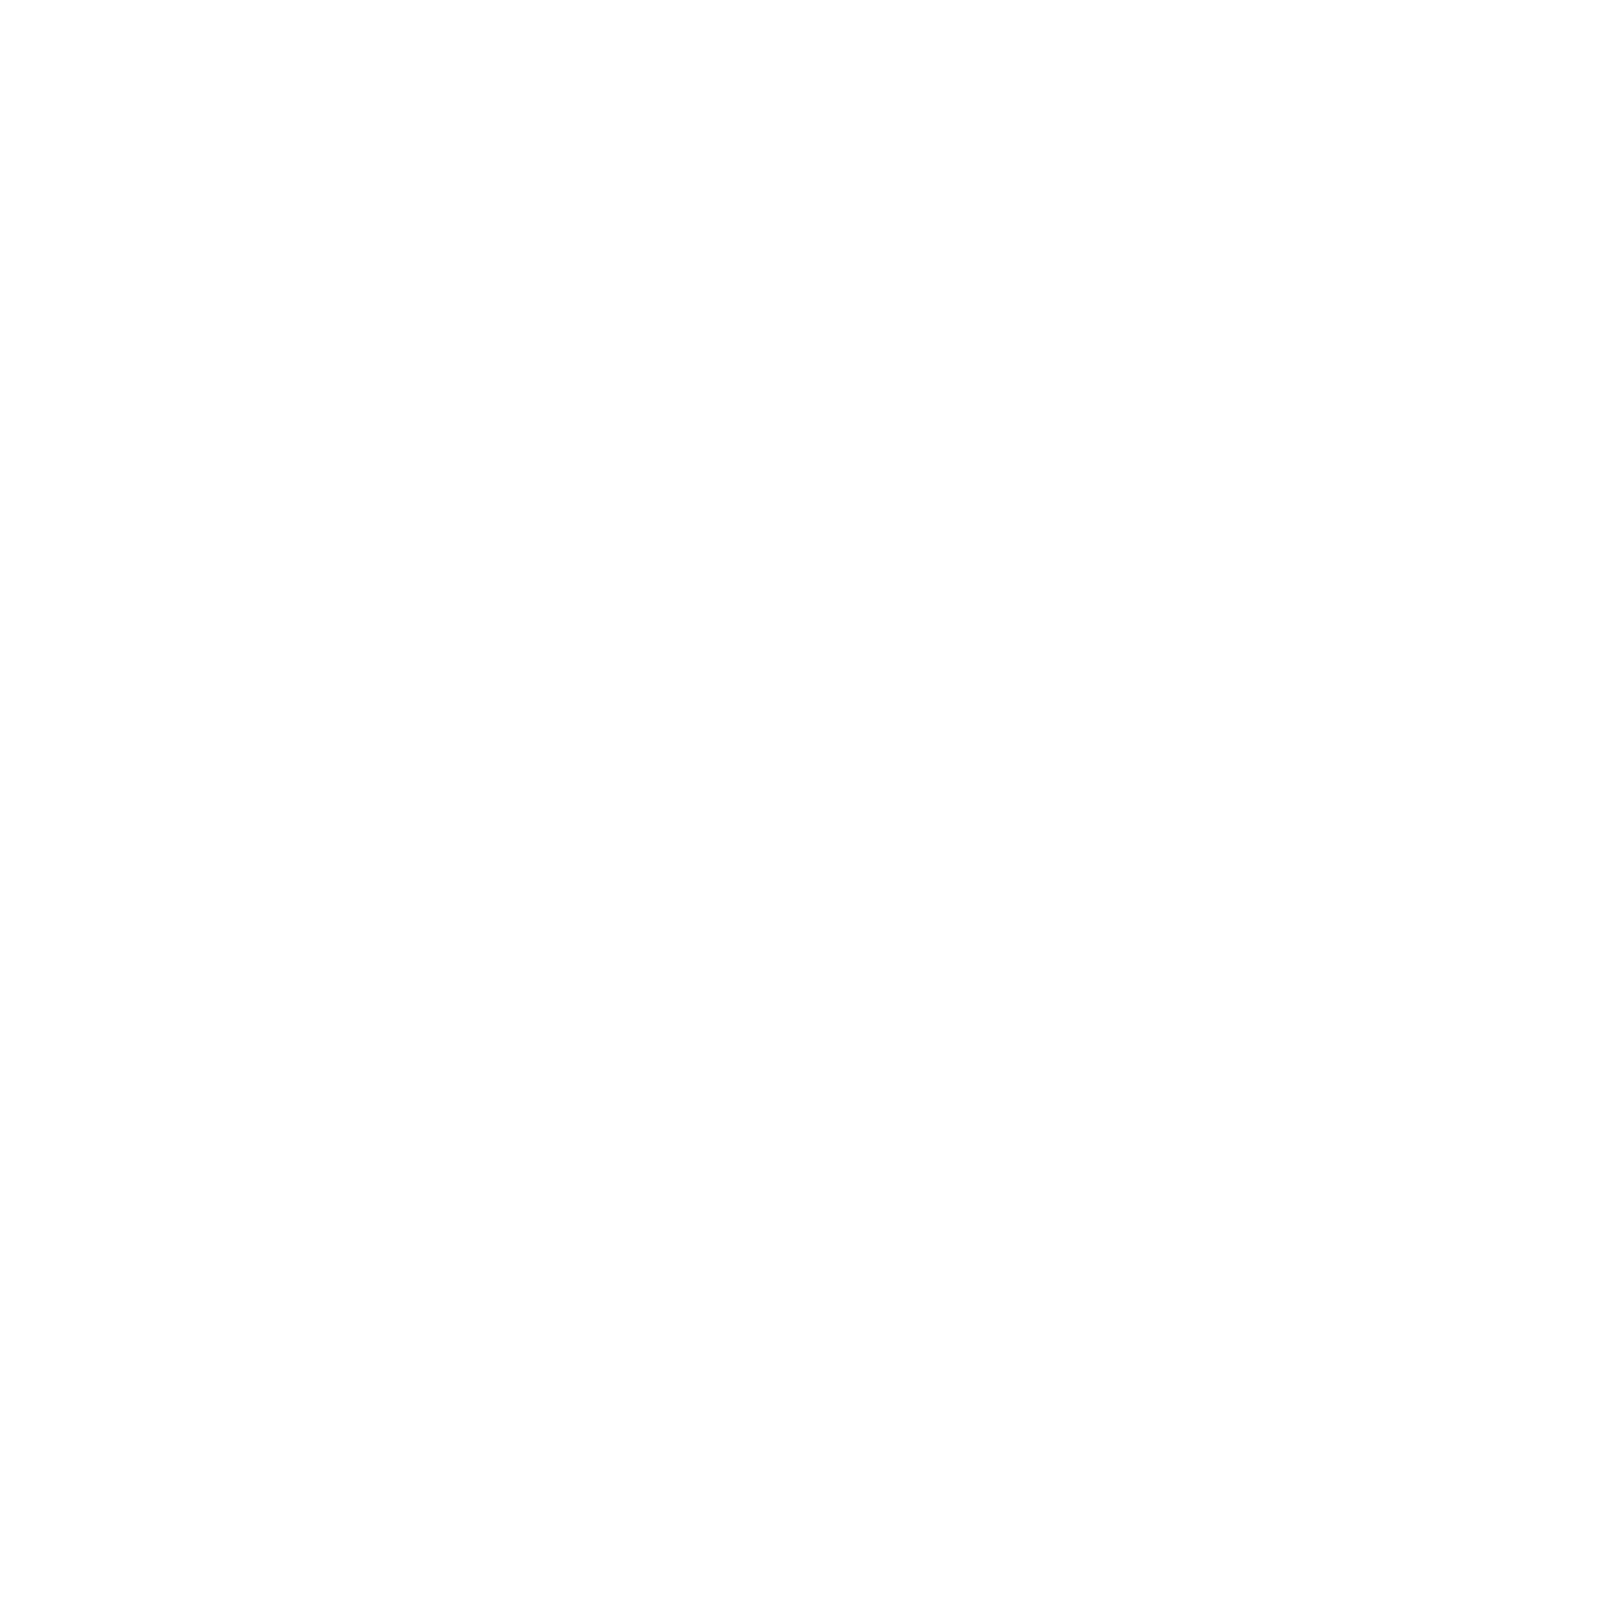

Loading PPDB Sources...
DIAObject ID: 176516734889492760
RA (deg): [154.92871652]
Dec (deg): [-5.82525465]
Number of DIASources: 21
Template patch: 12,7


<IPython.core.display.Javascript object>


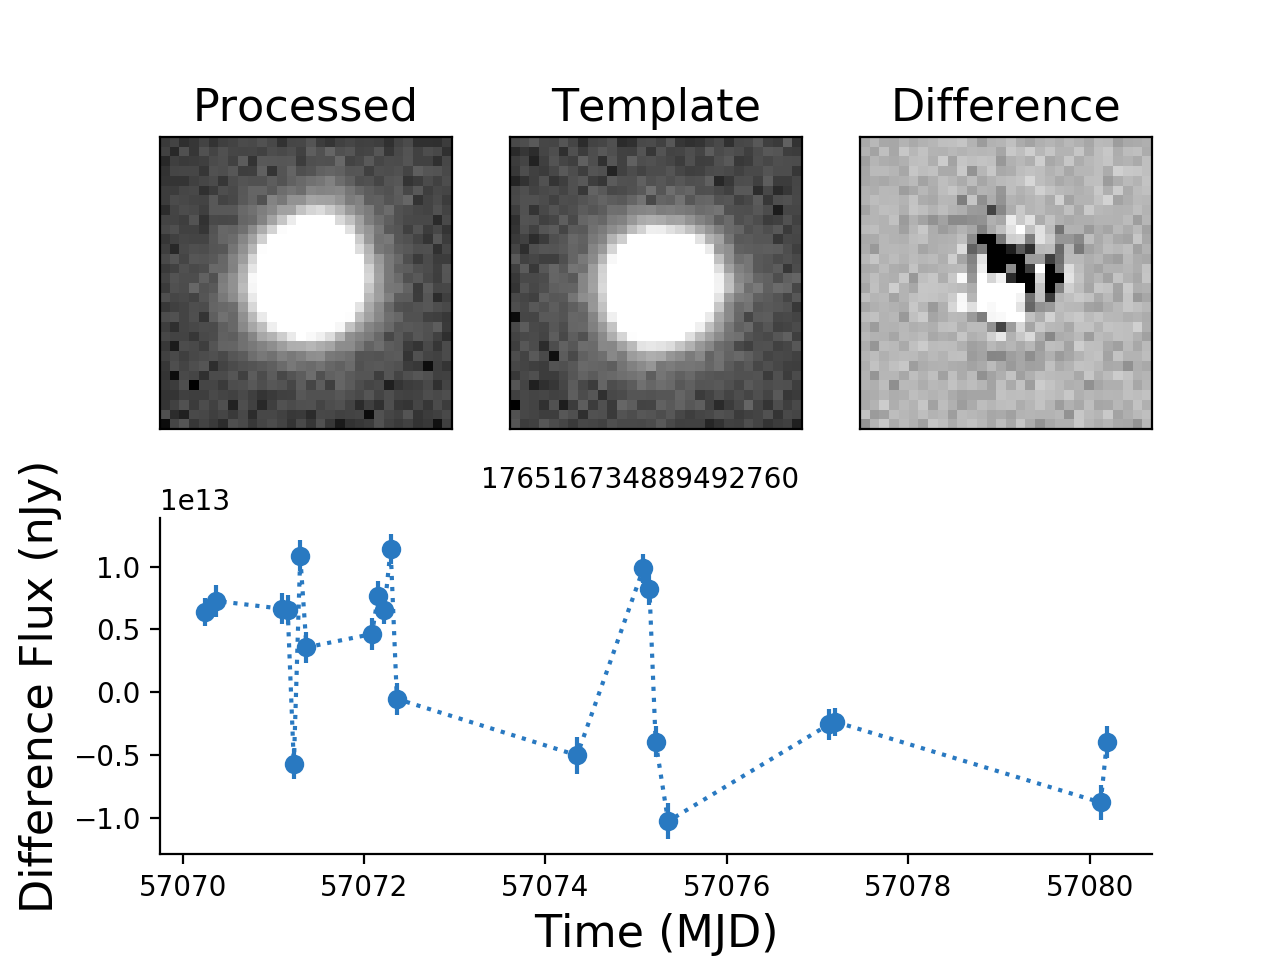

<IPython.core.display.Javascript object>


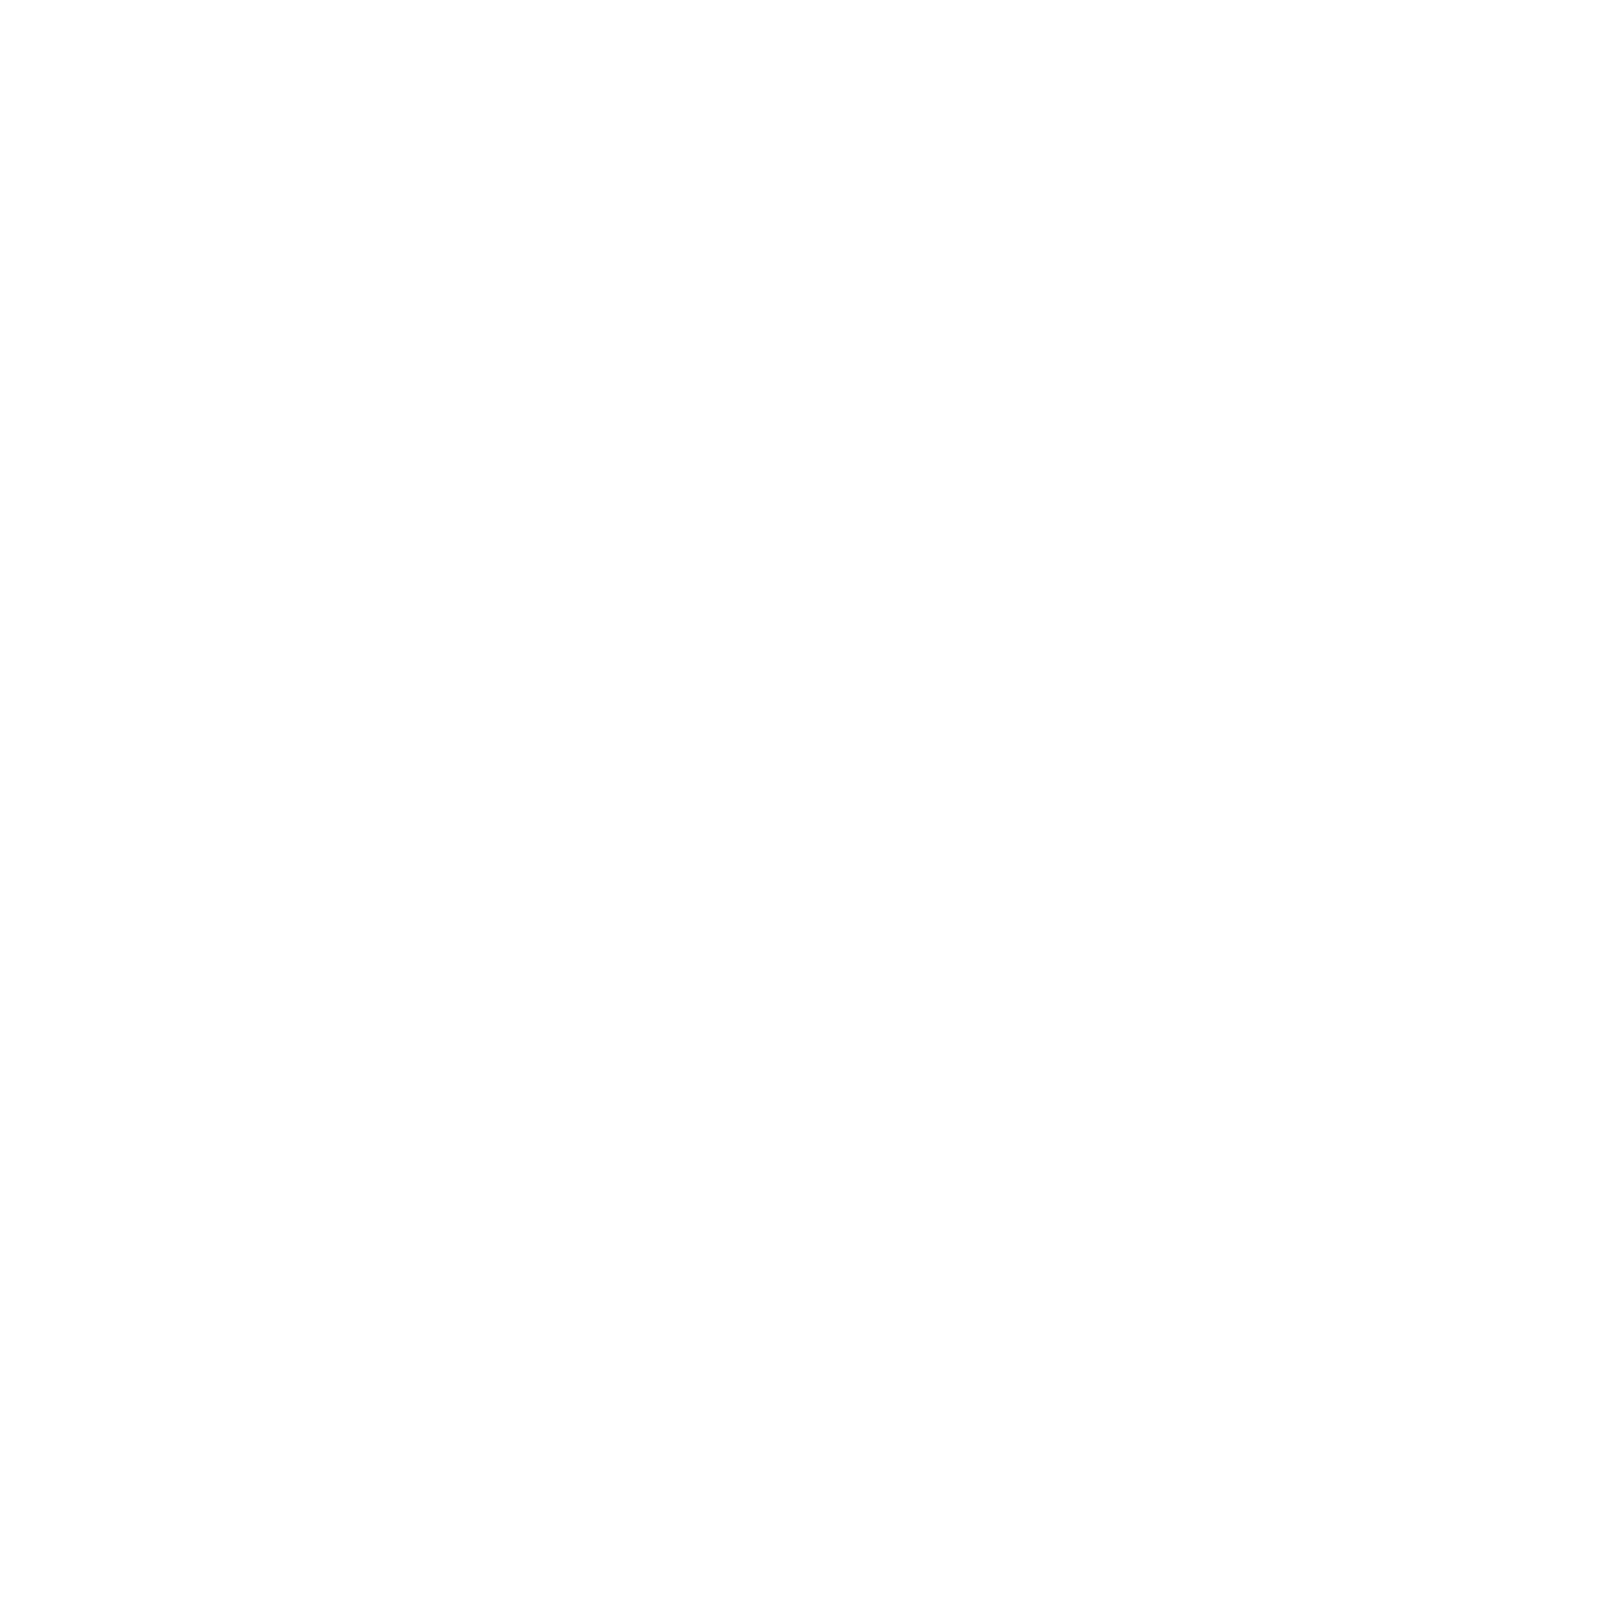

Loading PPDB Sources...
DIAObject ID: 176493778289295574
RA (deg): [155.19137335]
Dec (deg): [-5.80698673]
Number of DIASources: 23
Template patch: 11,8


<IPython.core.display.Javascript object>


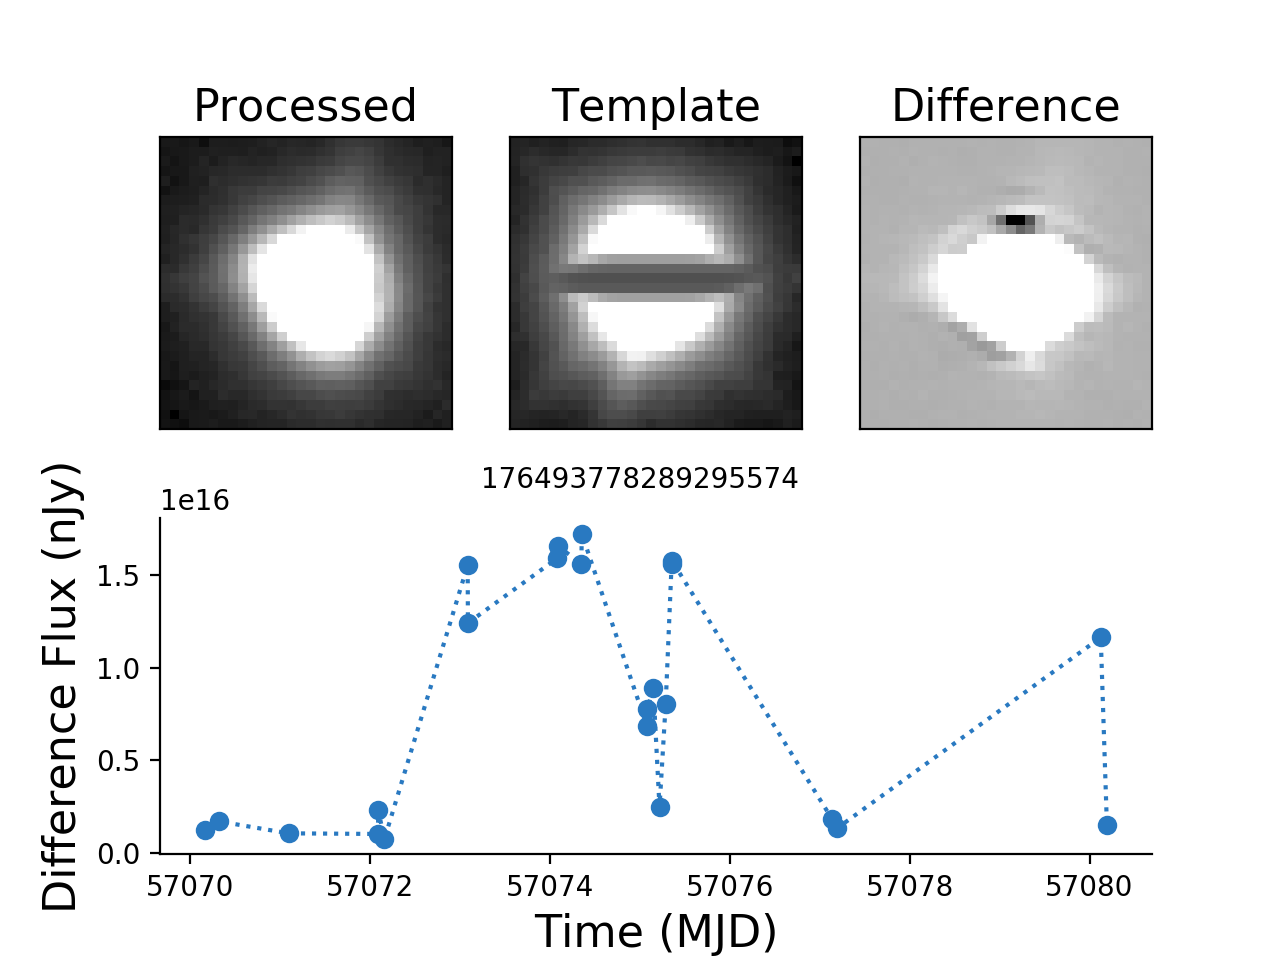

<IPython.core.display.Javascript object>


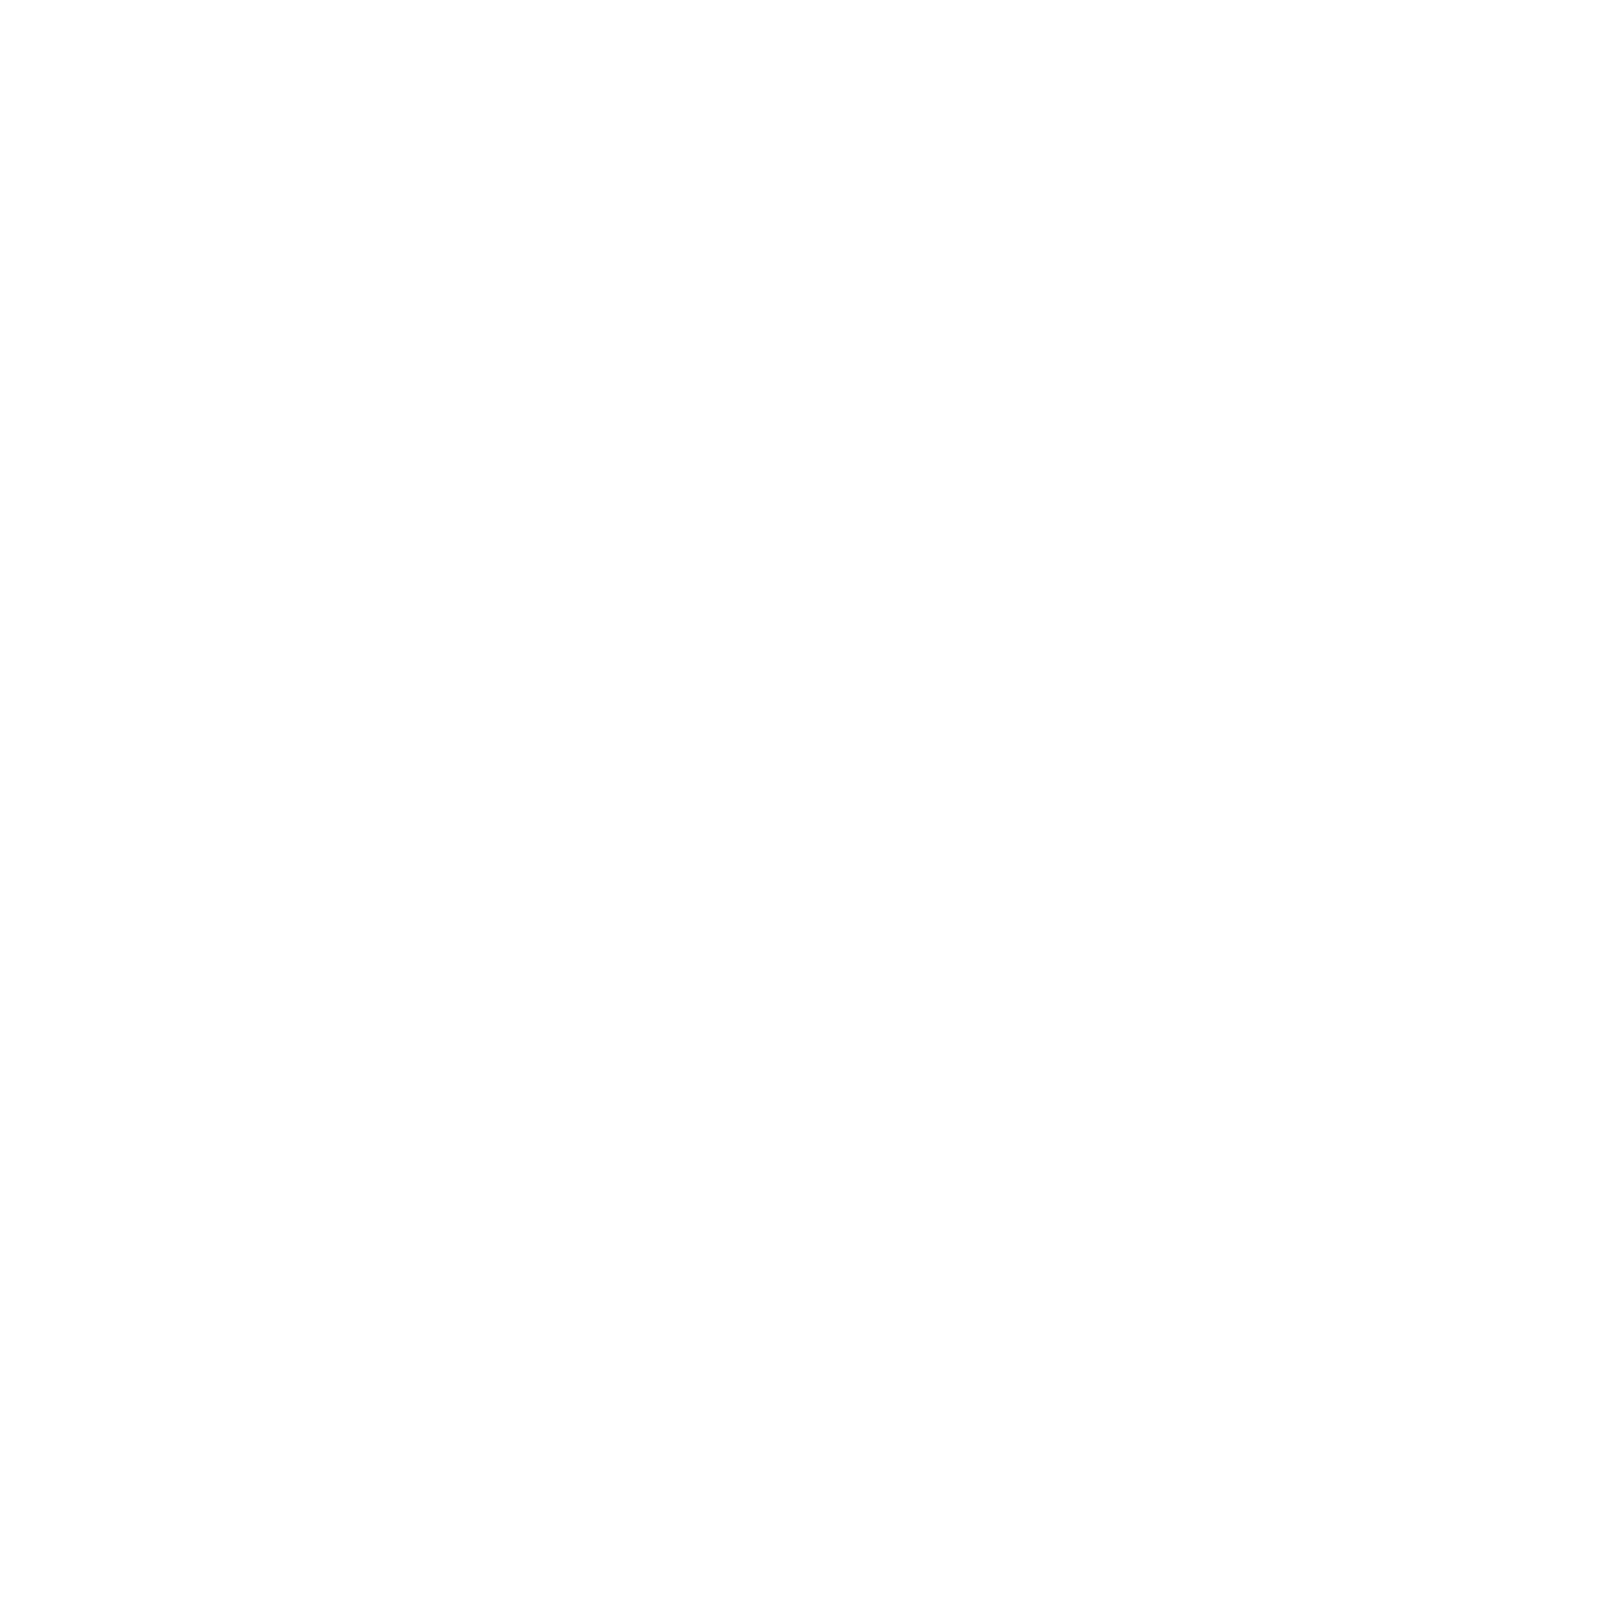

Loading PPDB Sources...
DIAObject ID: 176493778289295520
RA (deg): [155.00976983]
Dec (deg): [-5.92051779]
Number of DIASources: 20
Template patch: 11,7


<IPython.core.display.Javascript object>


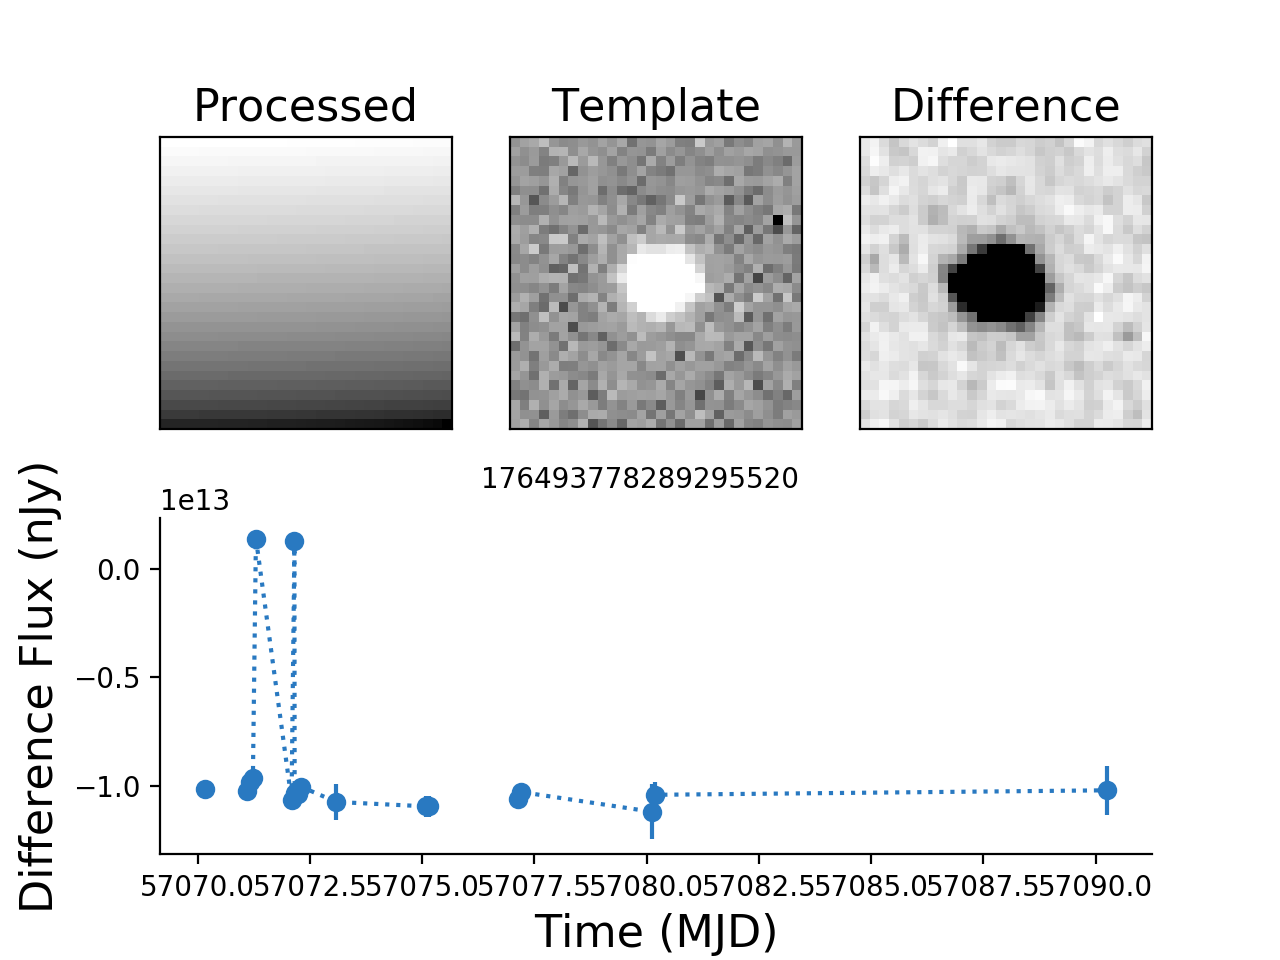

<IPython.core.display.Javascript object>


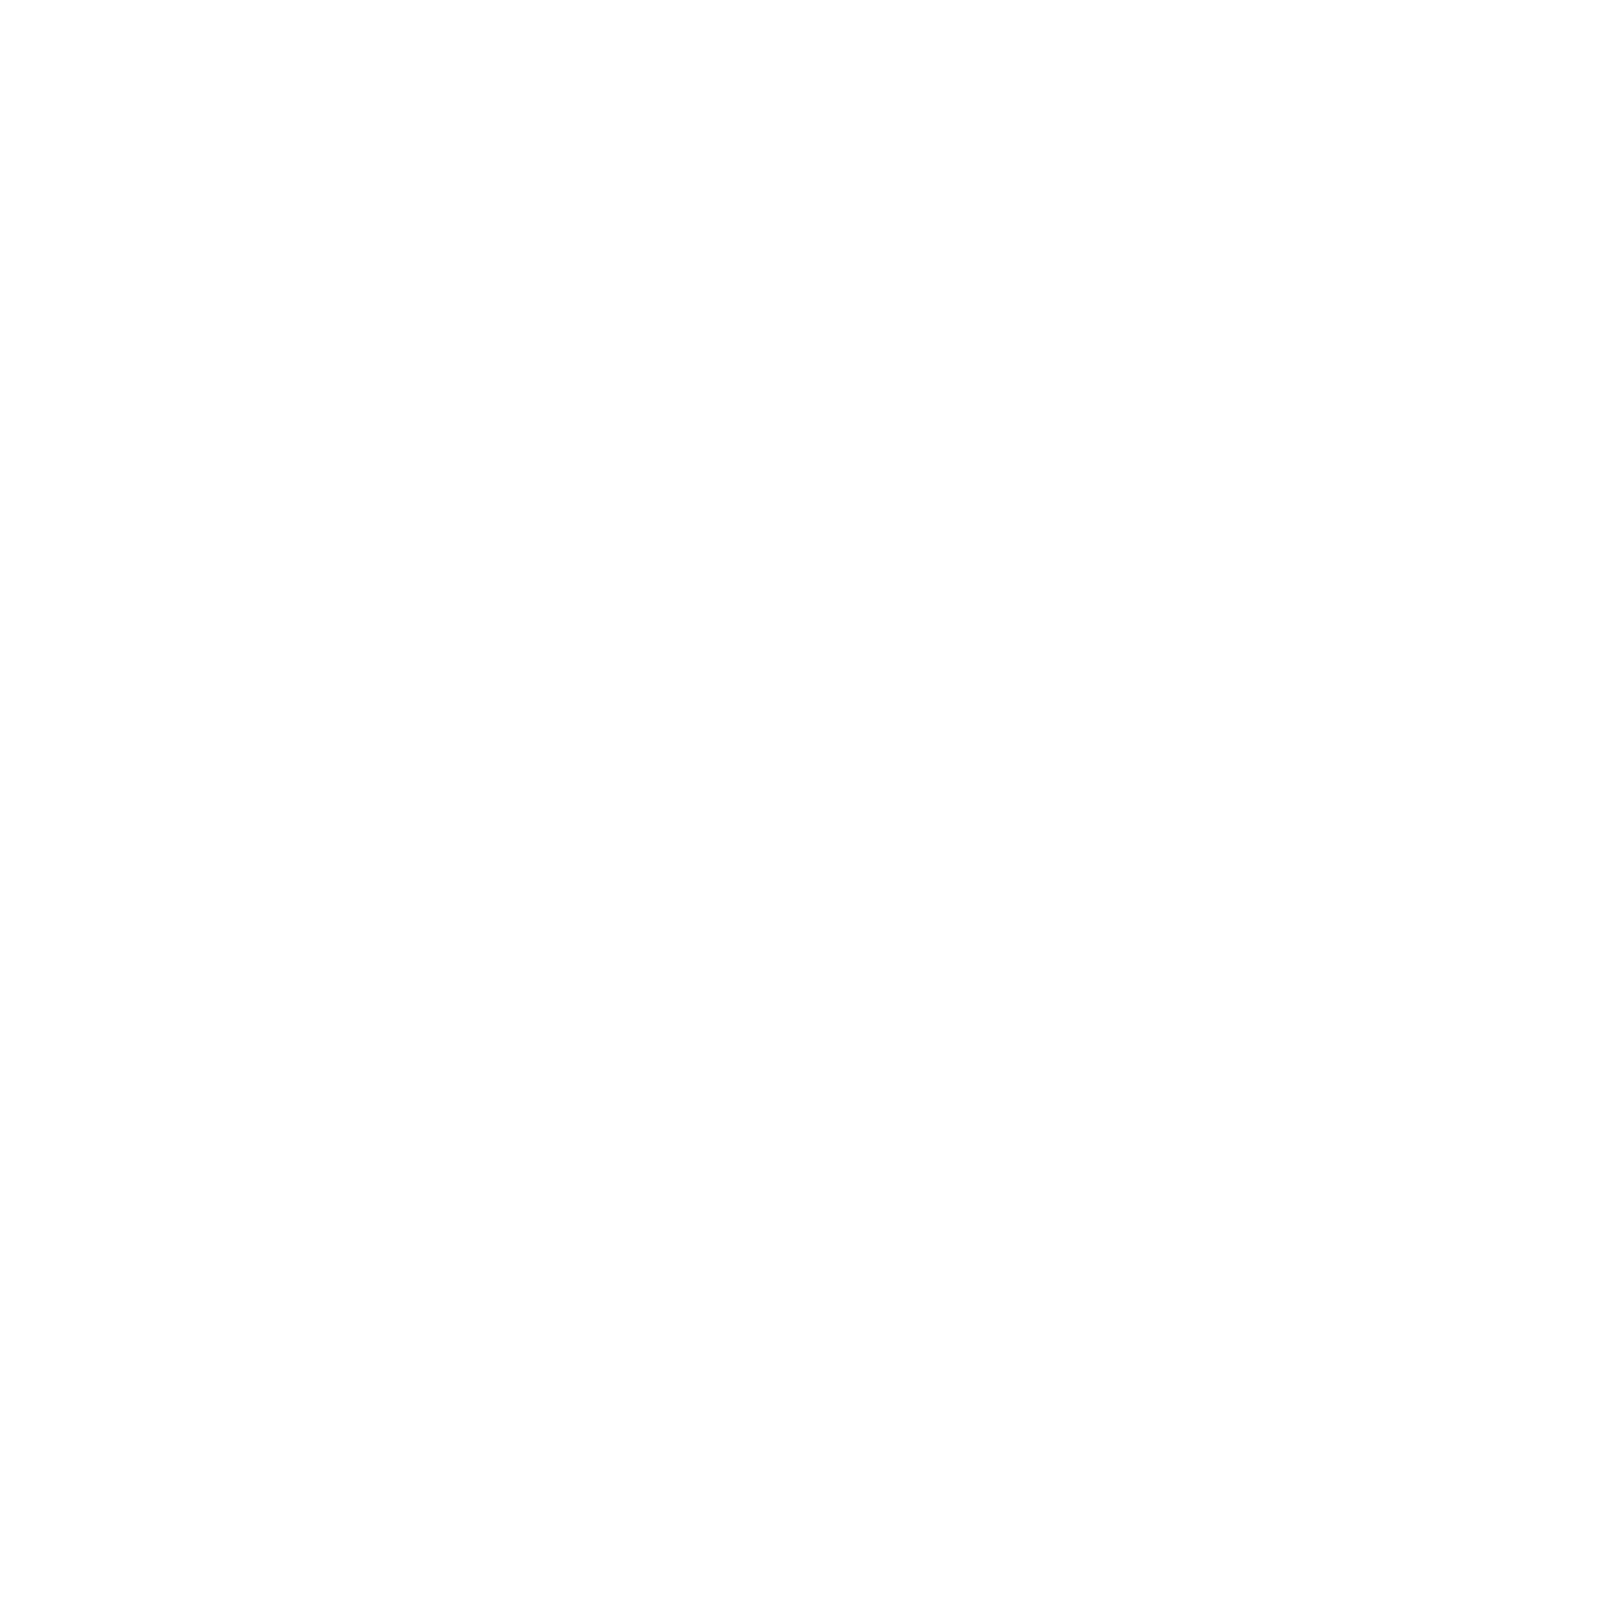

In [290]:
for obj in miniGoodObjDfMult['diaObjectId'].values[0:5]:
    plc.plotLightcurve(obj, miniGoodObjDf, repo, dbPath, repo, patchList, plotAllCutouts=True)

Loading PPDB Sources...
DIAObject ID: 176516756364329114
RA (deg): [155.06736401]
Dec (deg): [-5.89766196]
Number of DIASources: 24
Template patch: 11,7


<IPython.core.display.Javascript object>


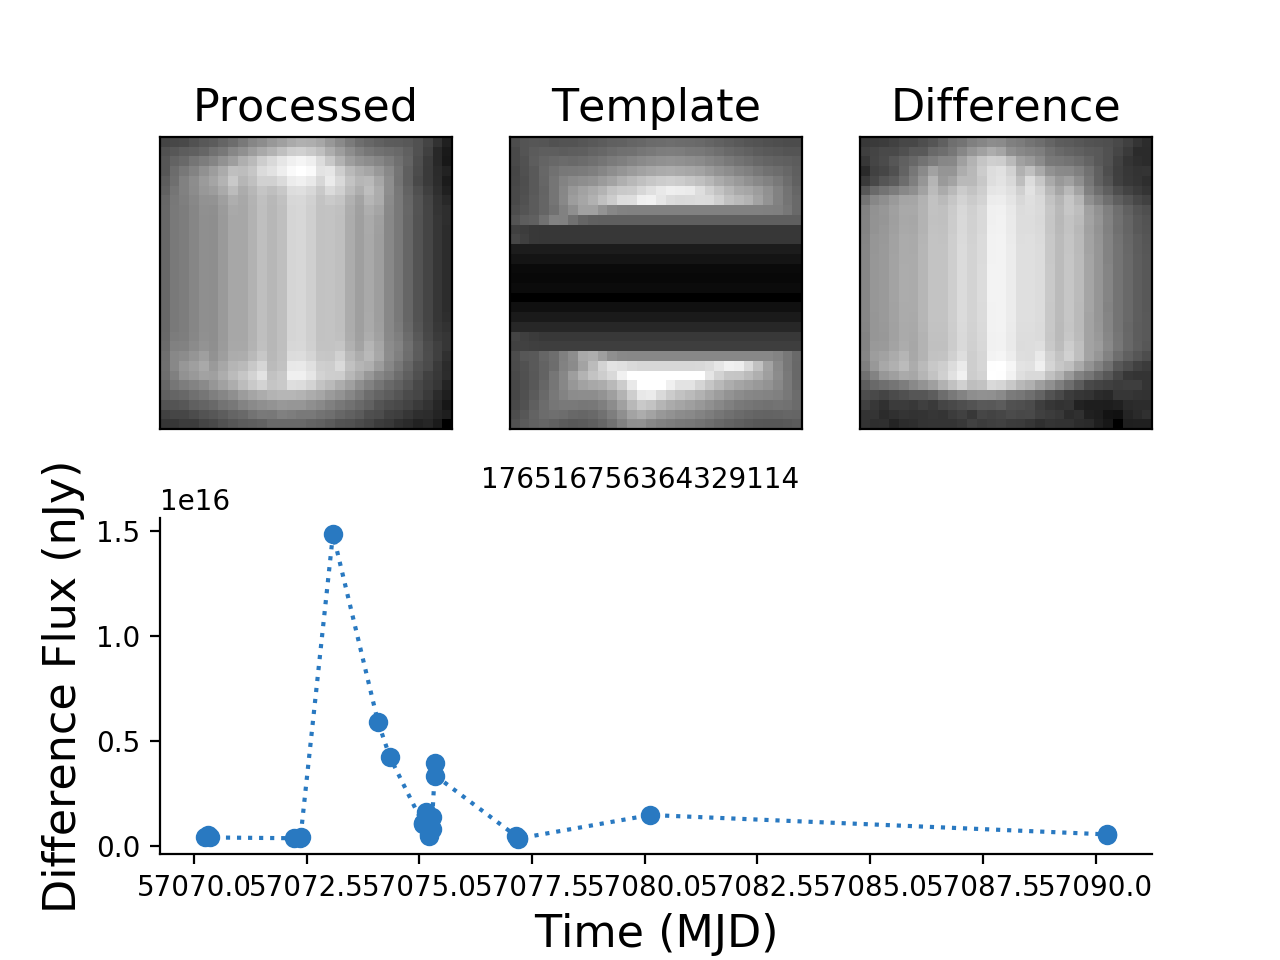

<IPython.core.display.Javascript object>


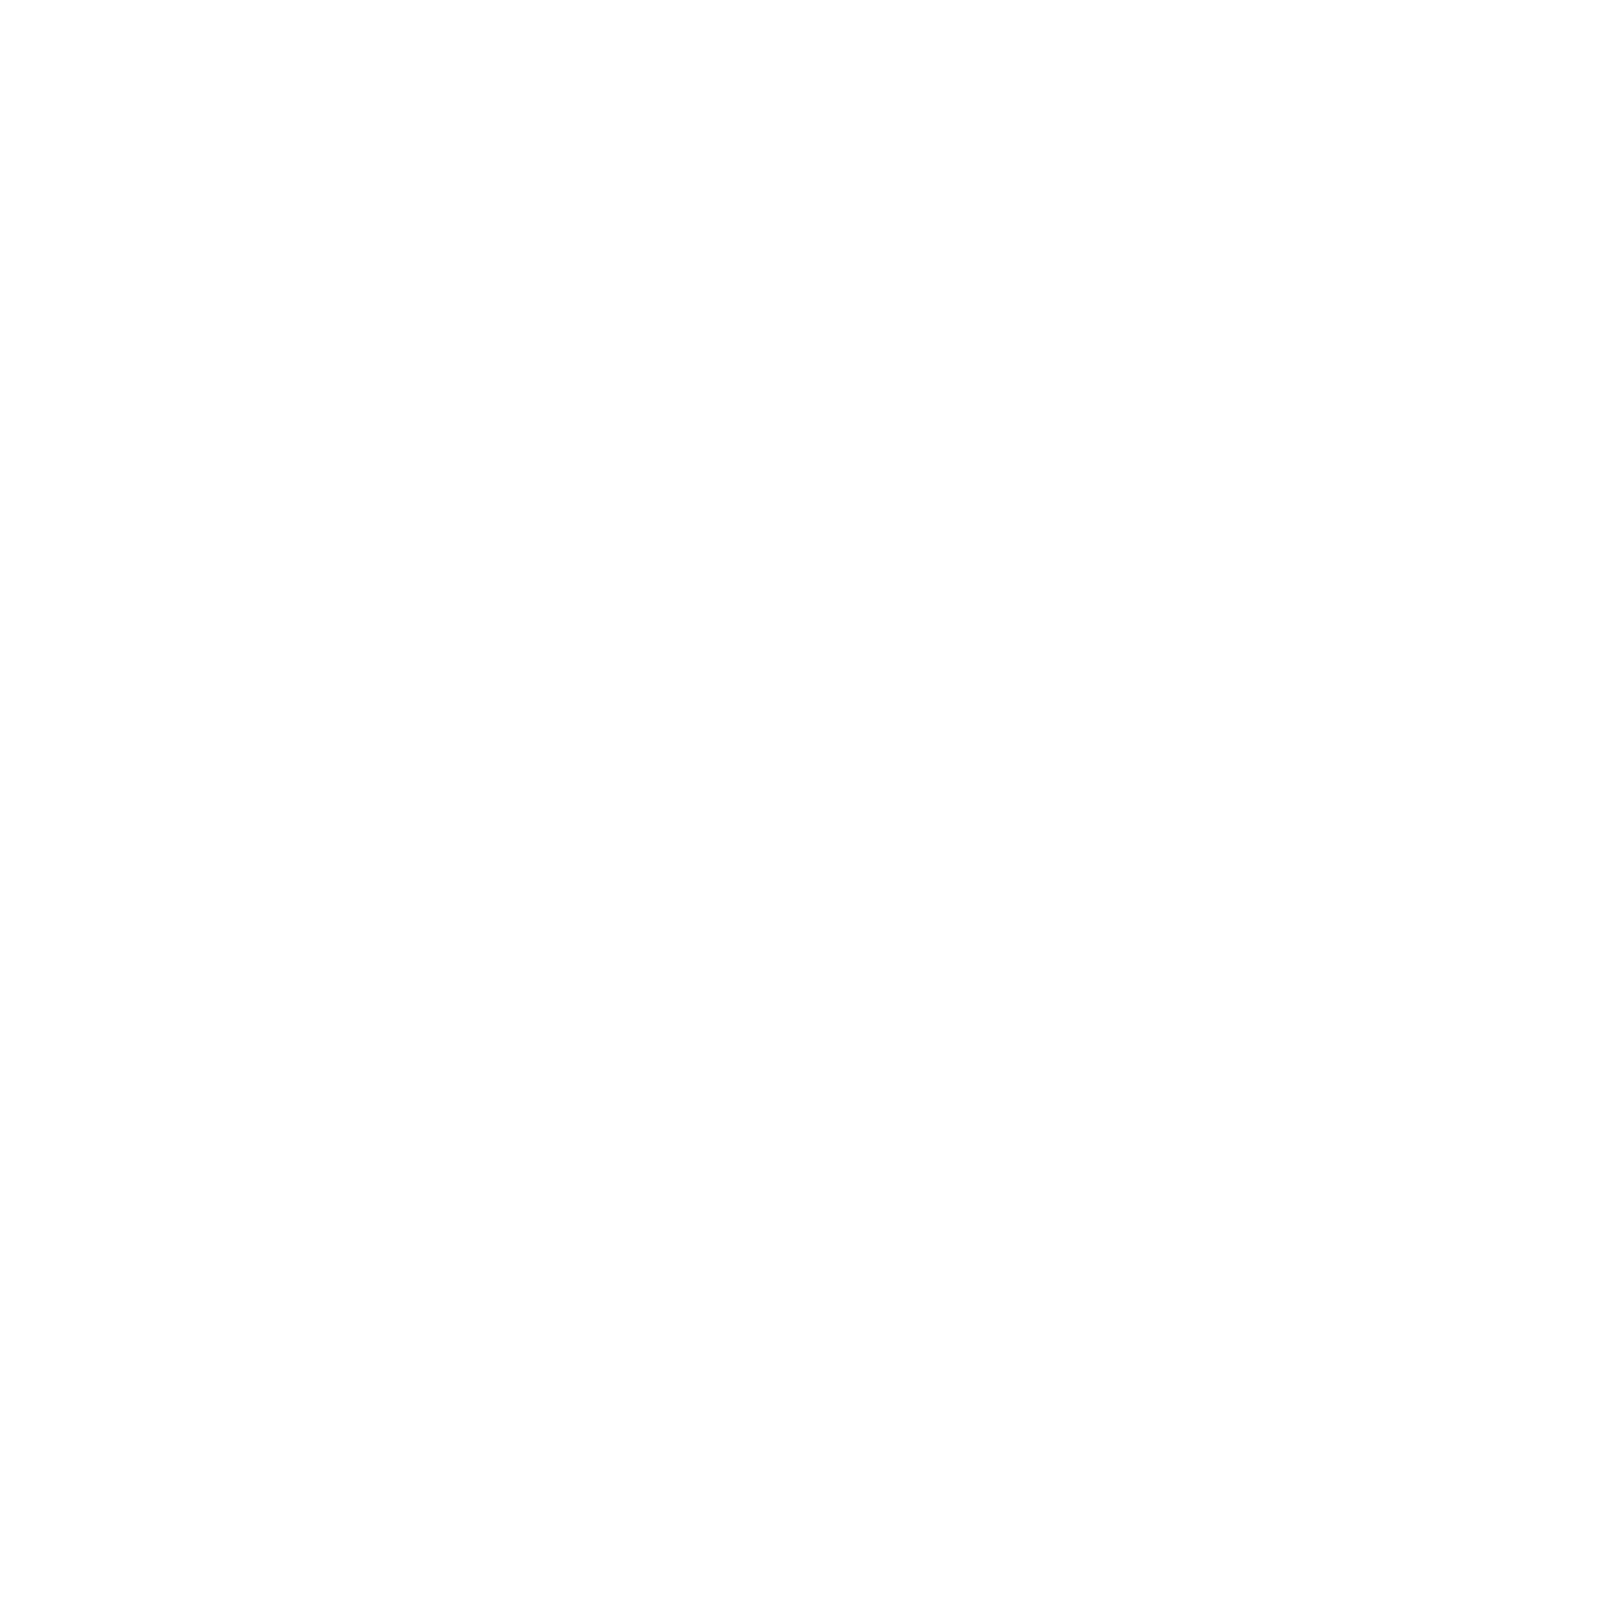

Loading PPDB Sources...
DIAObject ID: 176492665892766097
RA (deg): [154.80764002]
Dec (deg): [-5.62242369]
Number of DIASources: 26
Template patch: 12,8


<IPython.core.display.Javascript object>


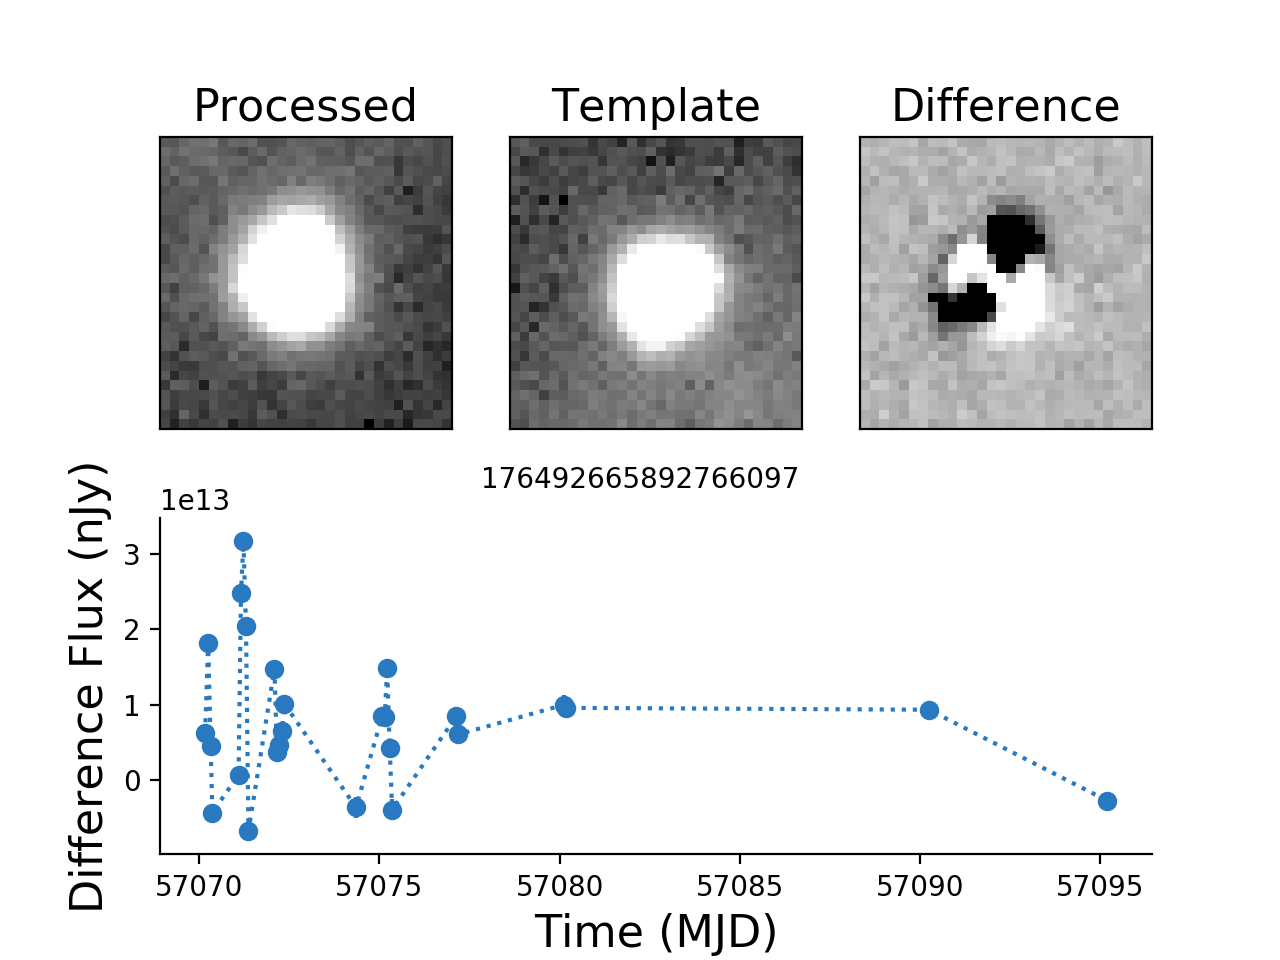

<IPython.core.display.Javascript object>


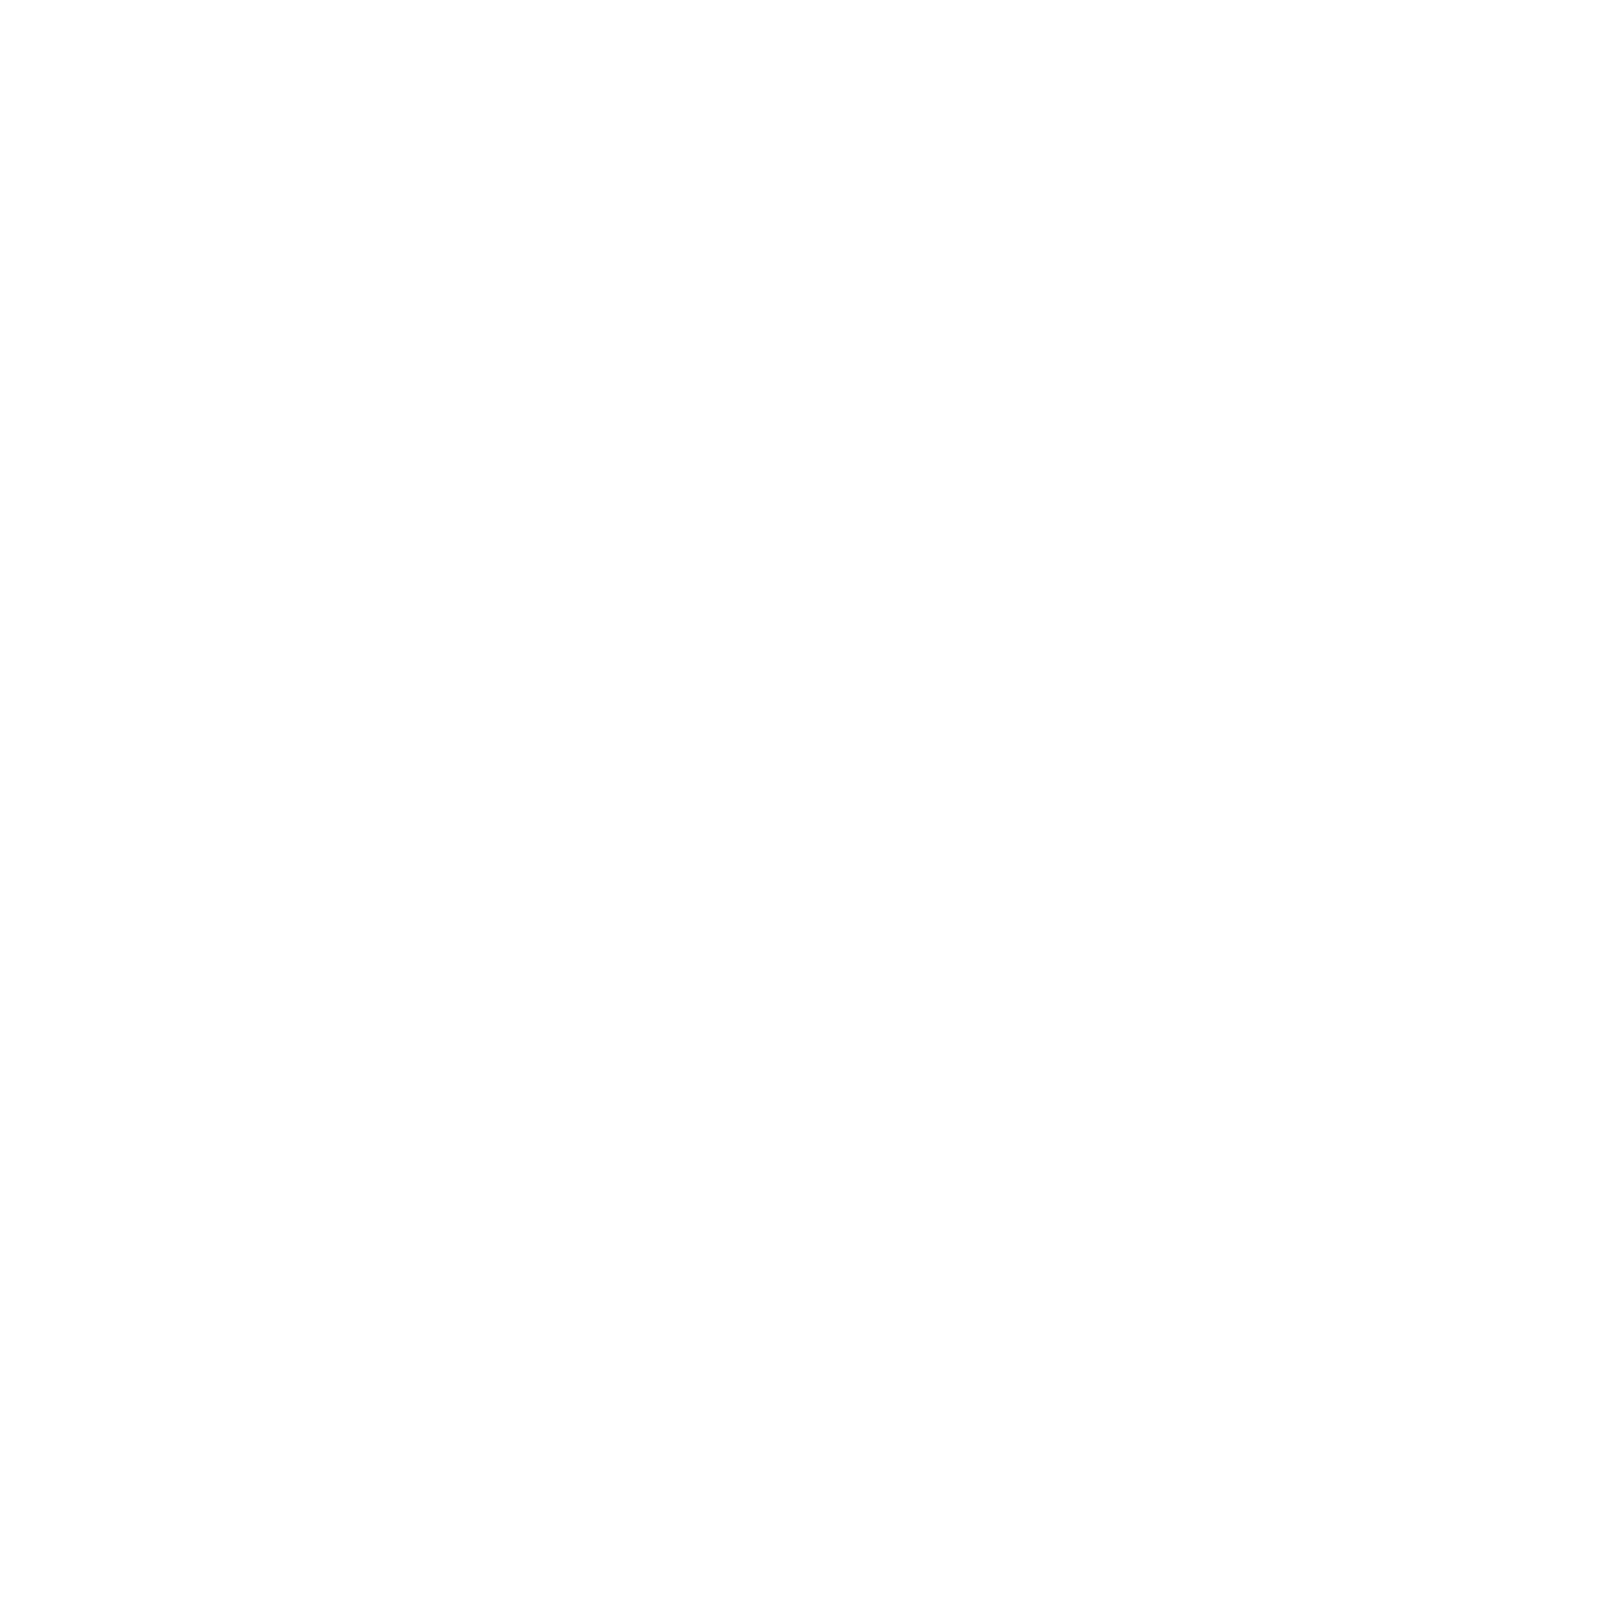

Loading PPDB Sources...
DIAObject ID: 176492665892766107
RA (deg): [154.83132555]
Dec (deg): [-5.64825738]
Number of DIASources: 25
Template patch: 12,8


<IPython.core.display.Javascript object>


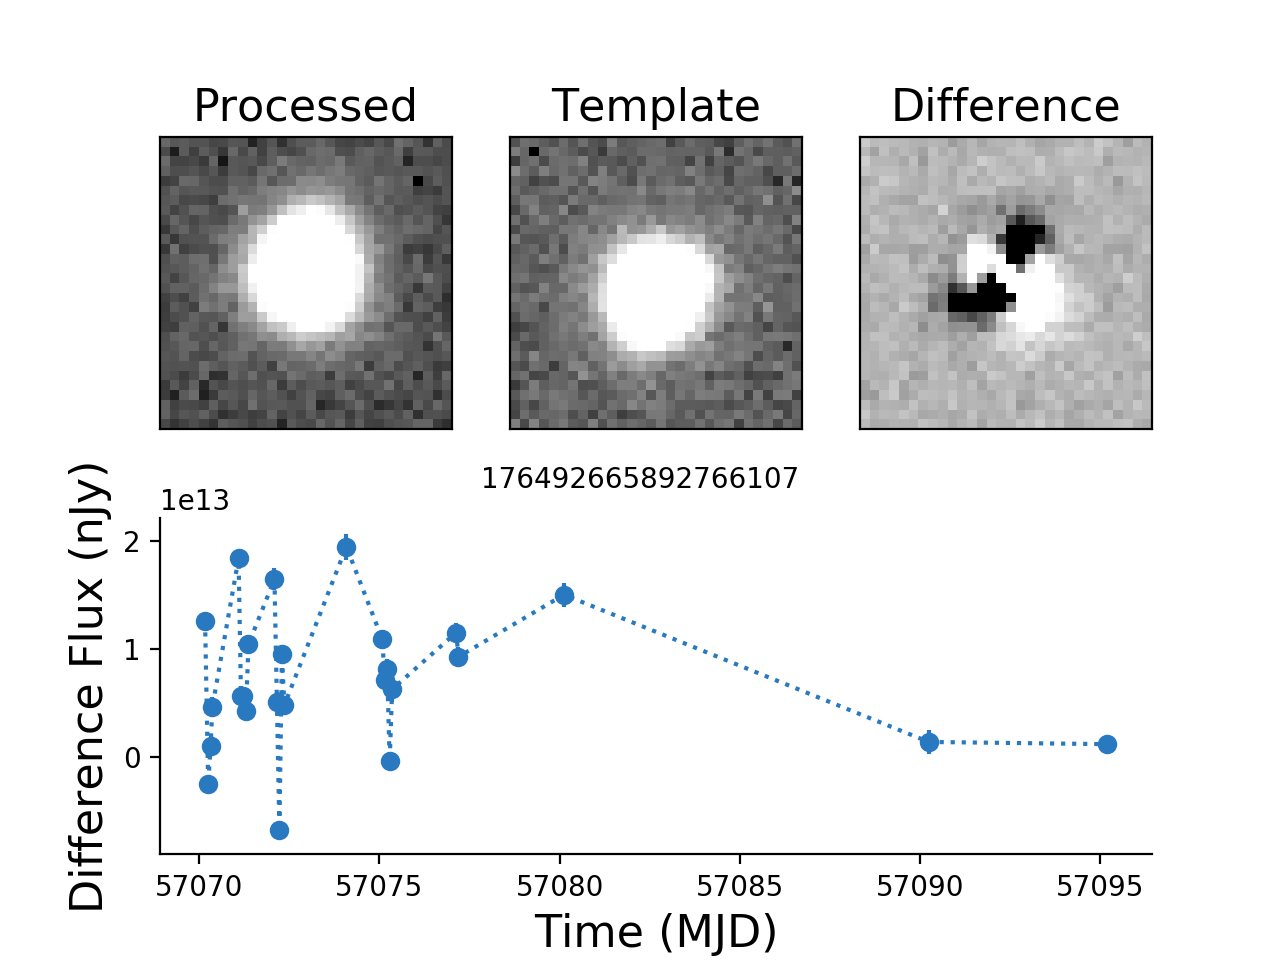

<IPython.core.display.Javascript object>


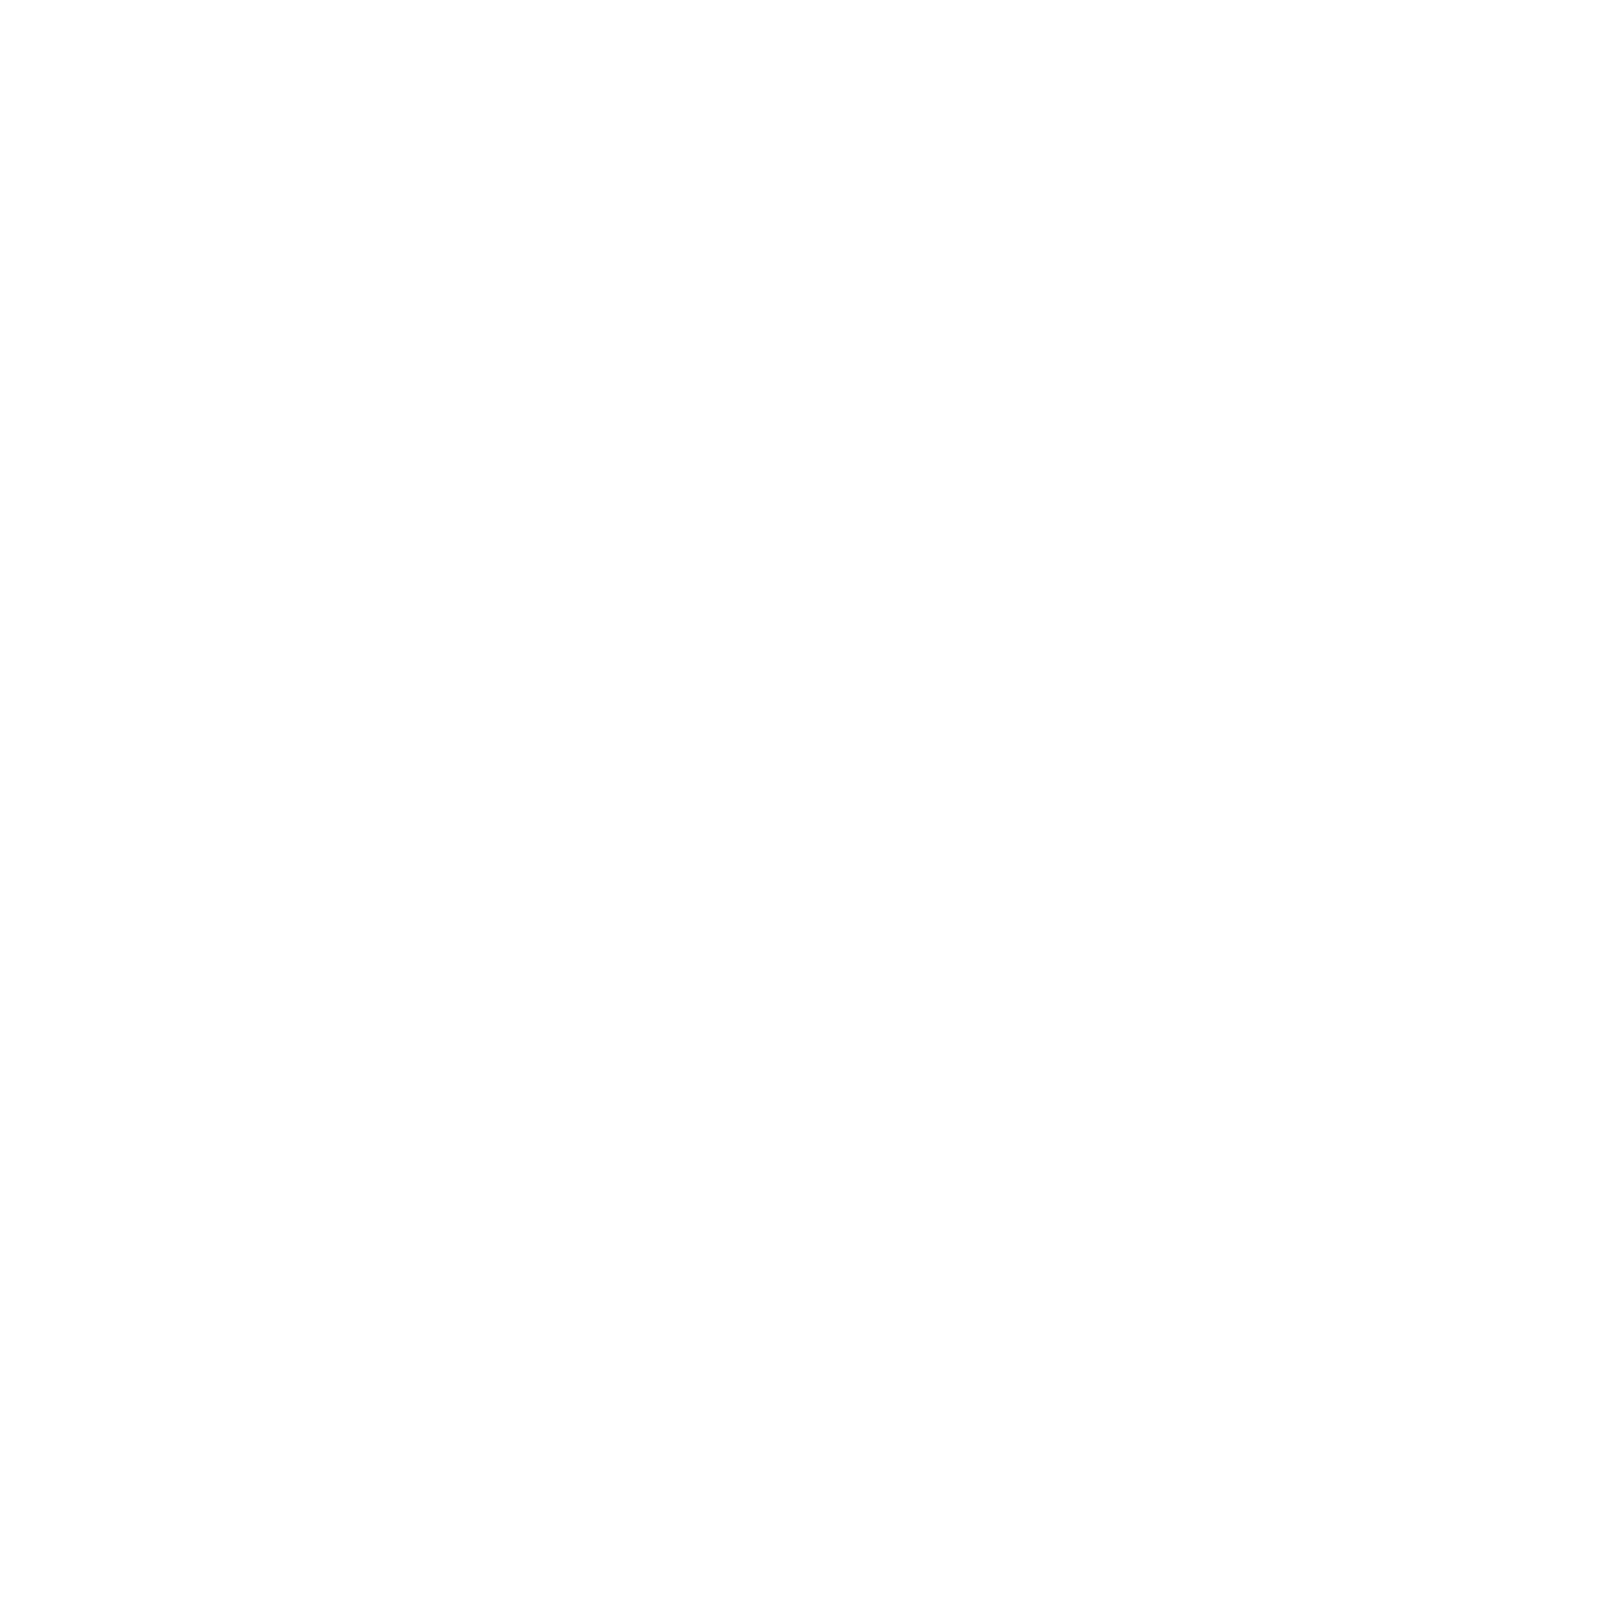

Loading PPDB Sources...
DIAObject ID: 176492665892766157
RA (deg): [154.8692689]
Dec (deg): [-5.61080193]
Number of DIASources: 20
Template patch: 12,8


<IPython.core.display.Javascript object>


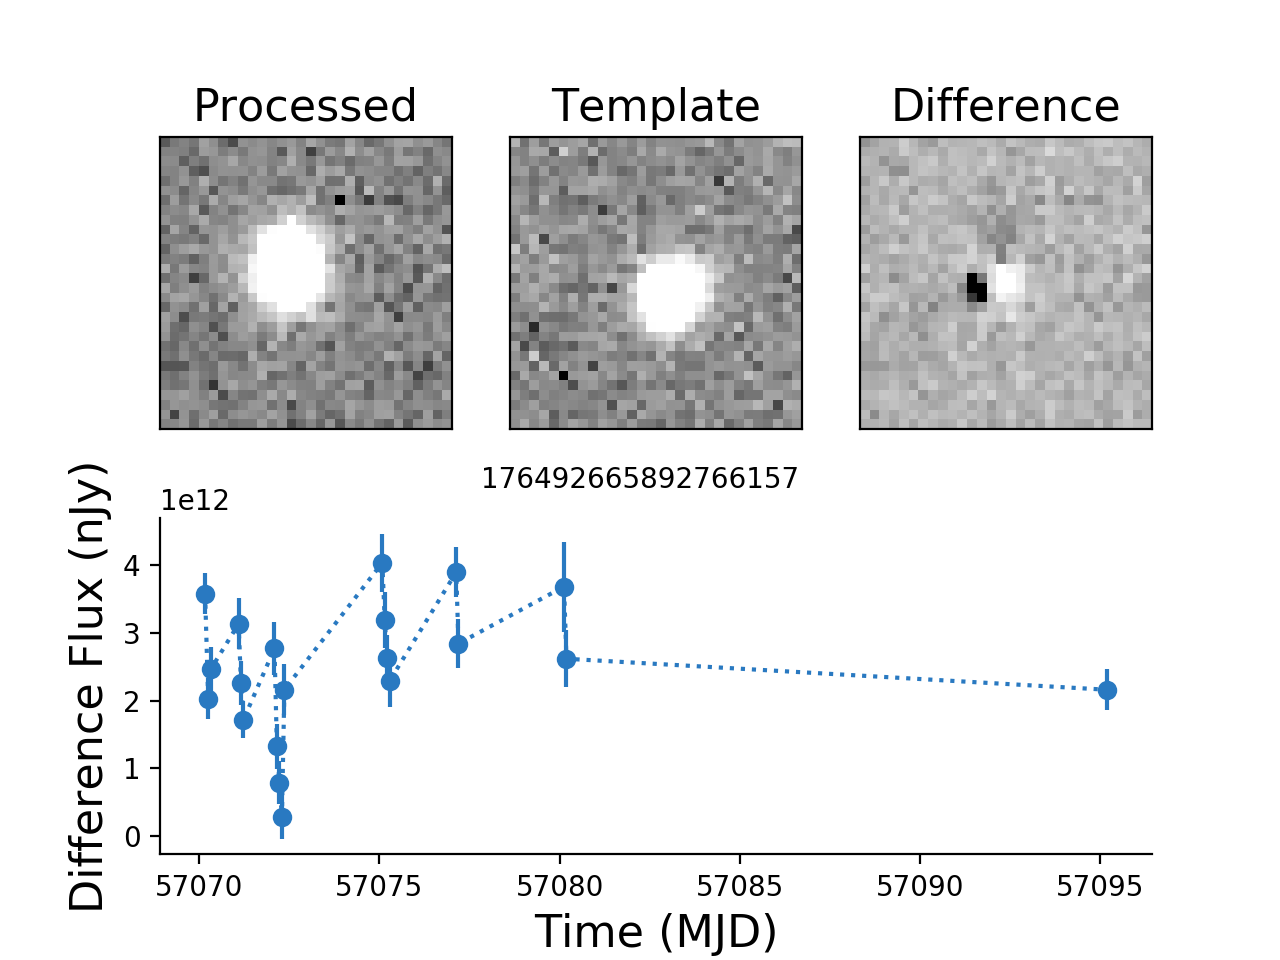

<IPython.core.display.Javascript object>


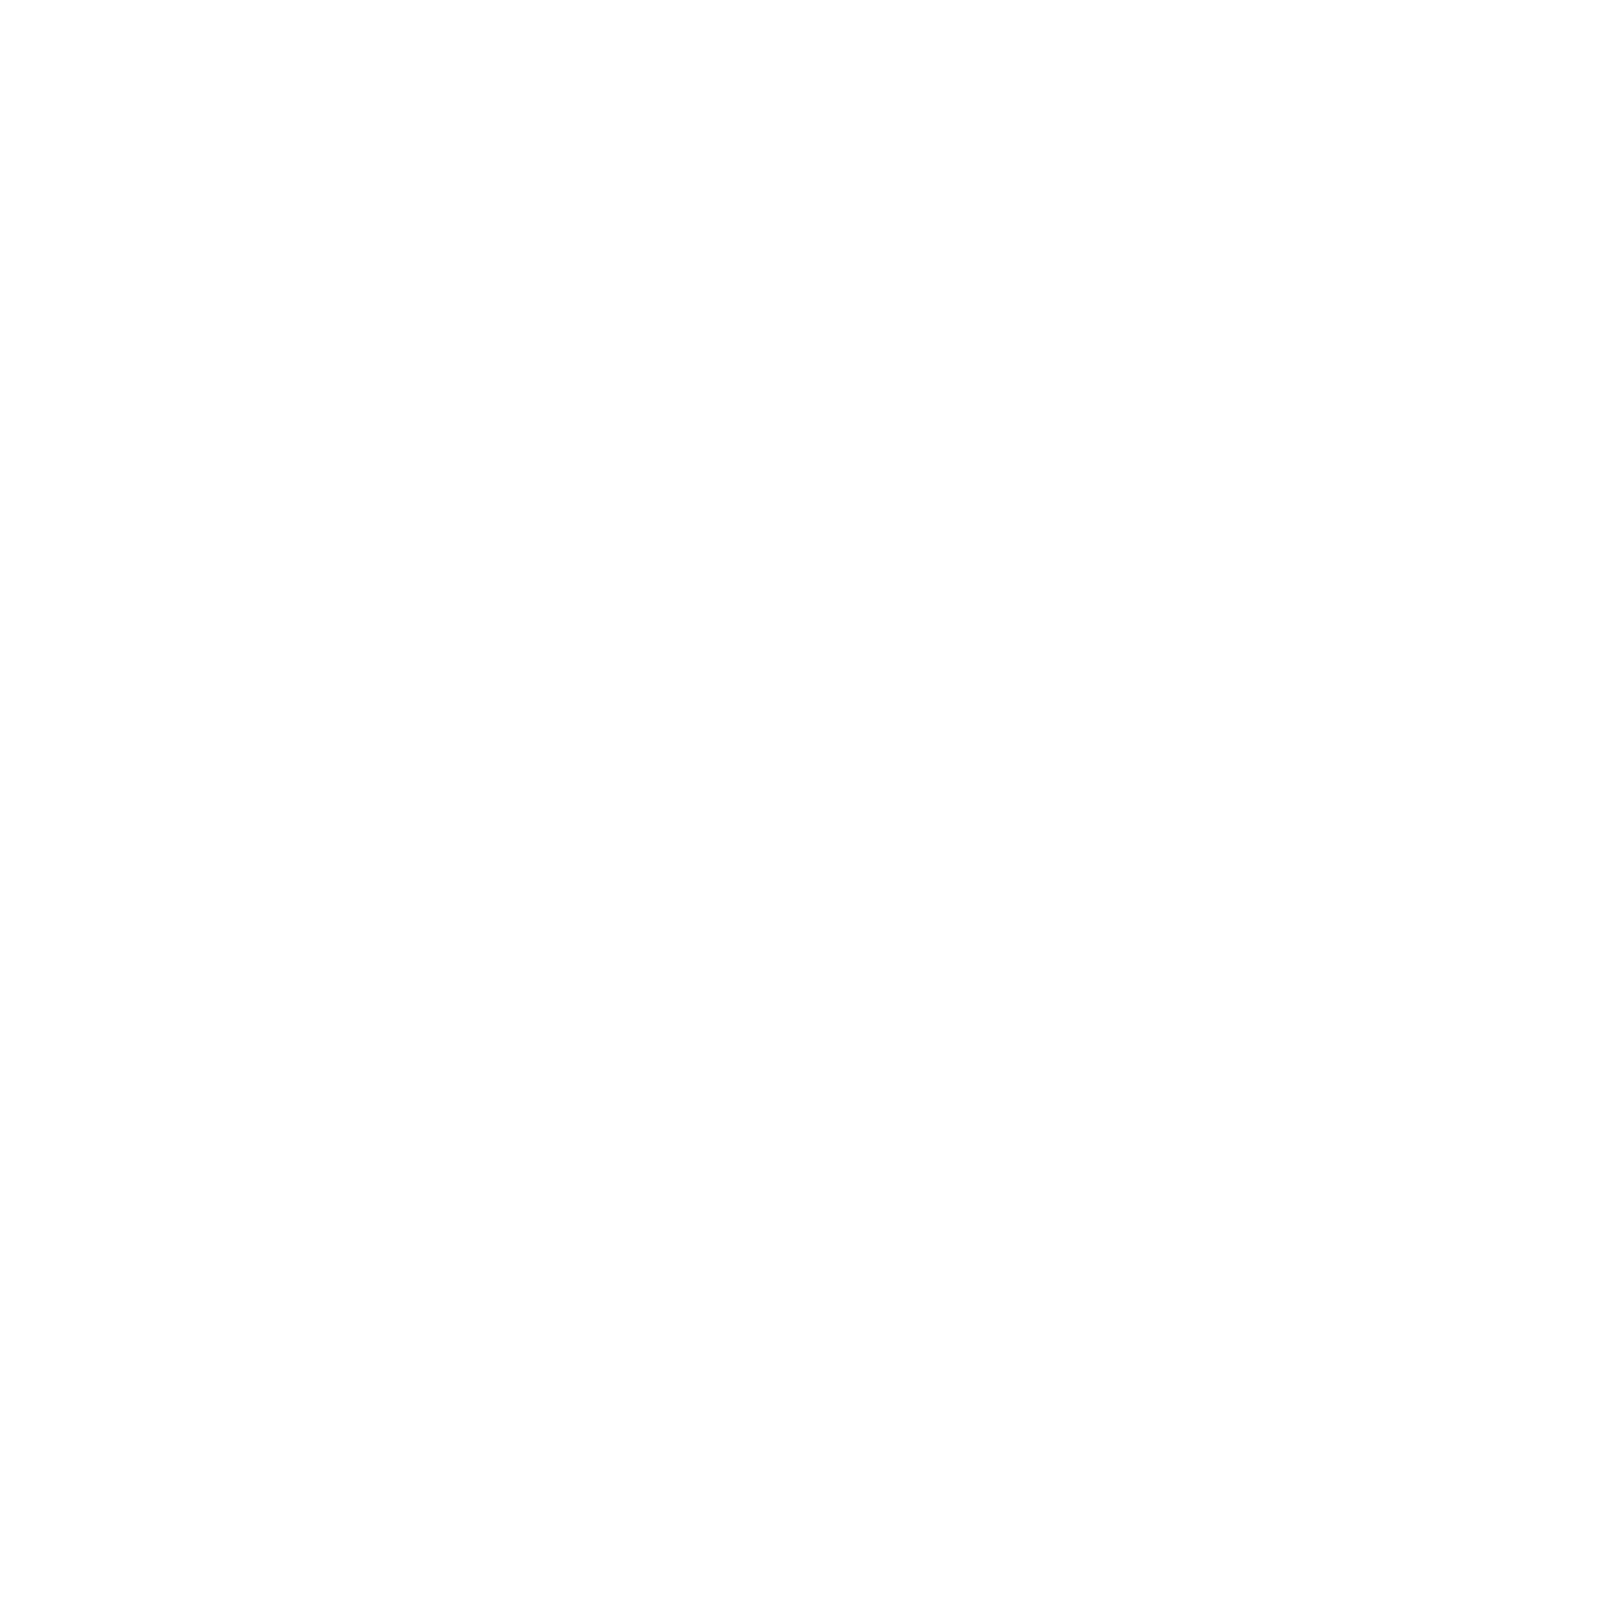

Loading PPDB Sources...
DIAObject ID: 176492665892766171
RA (deg): [154.89665205]
Dec (deg): [-5.65223176]
Number of DIASources: 31
Template patch: 12,8


<IPython.core.display.Javascript object>


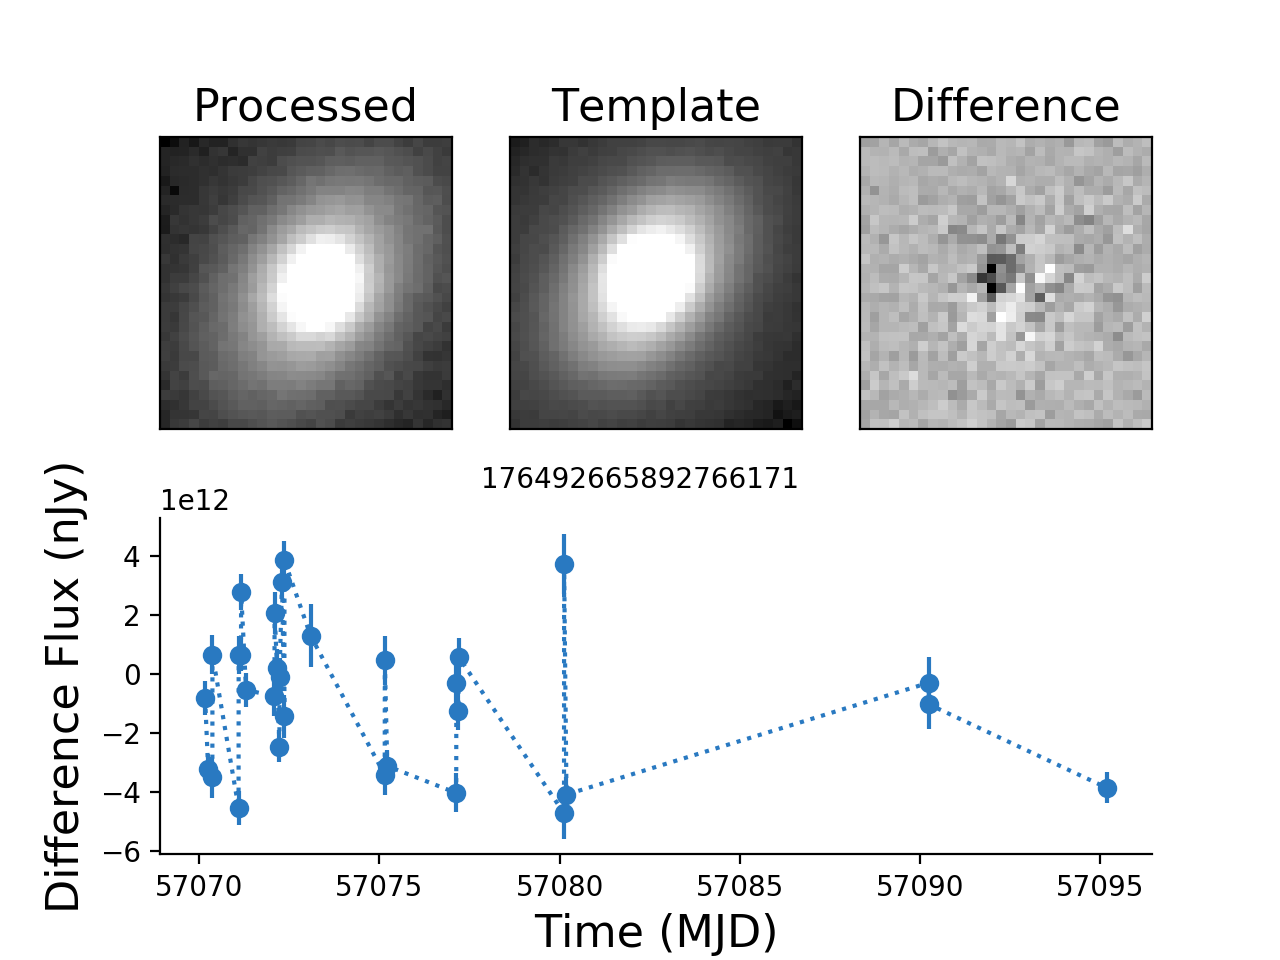

<IPython.core.display.Javascript object>


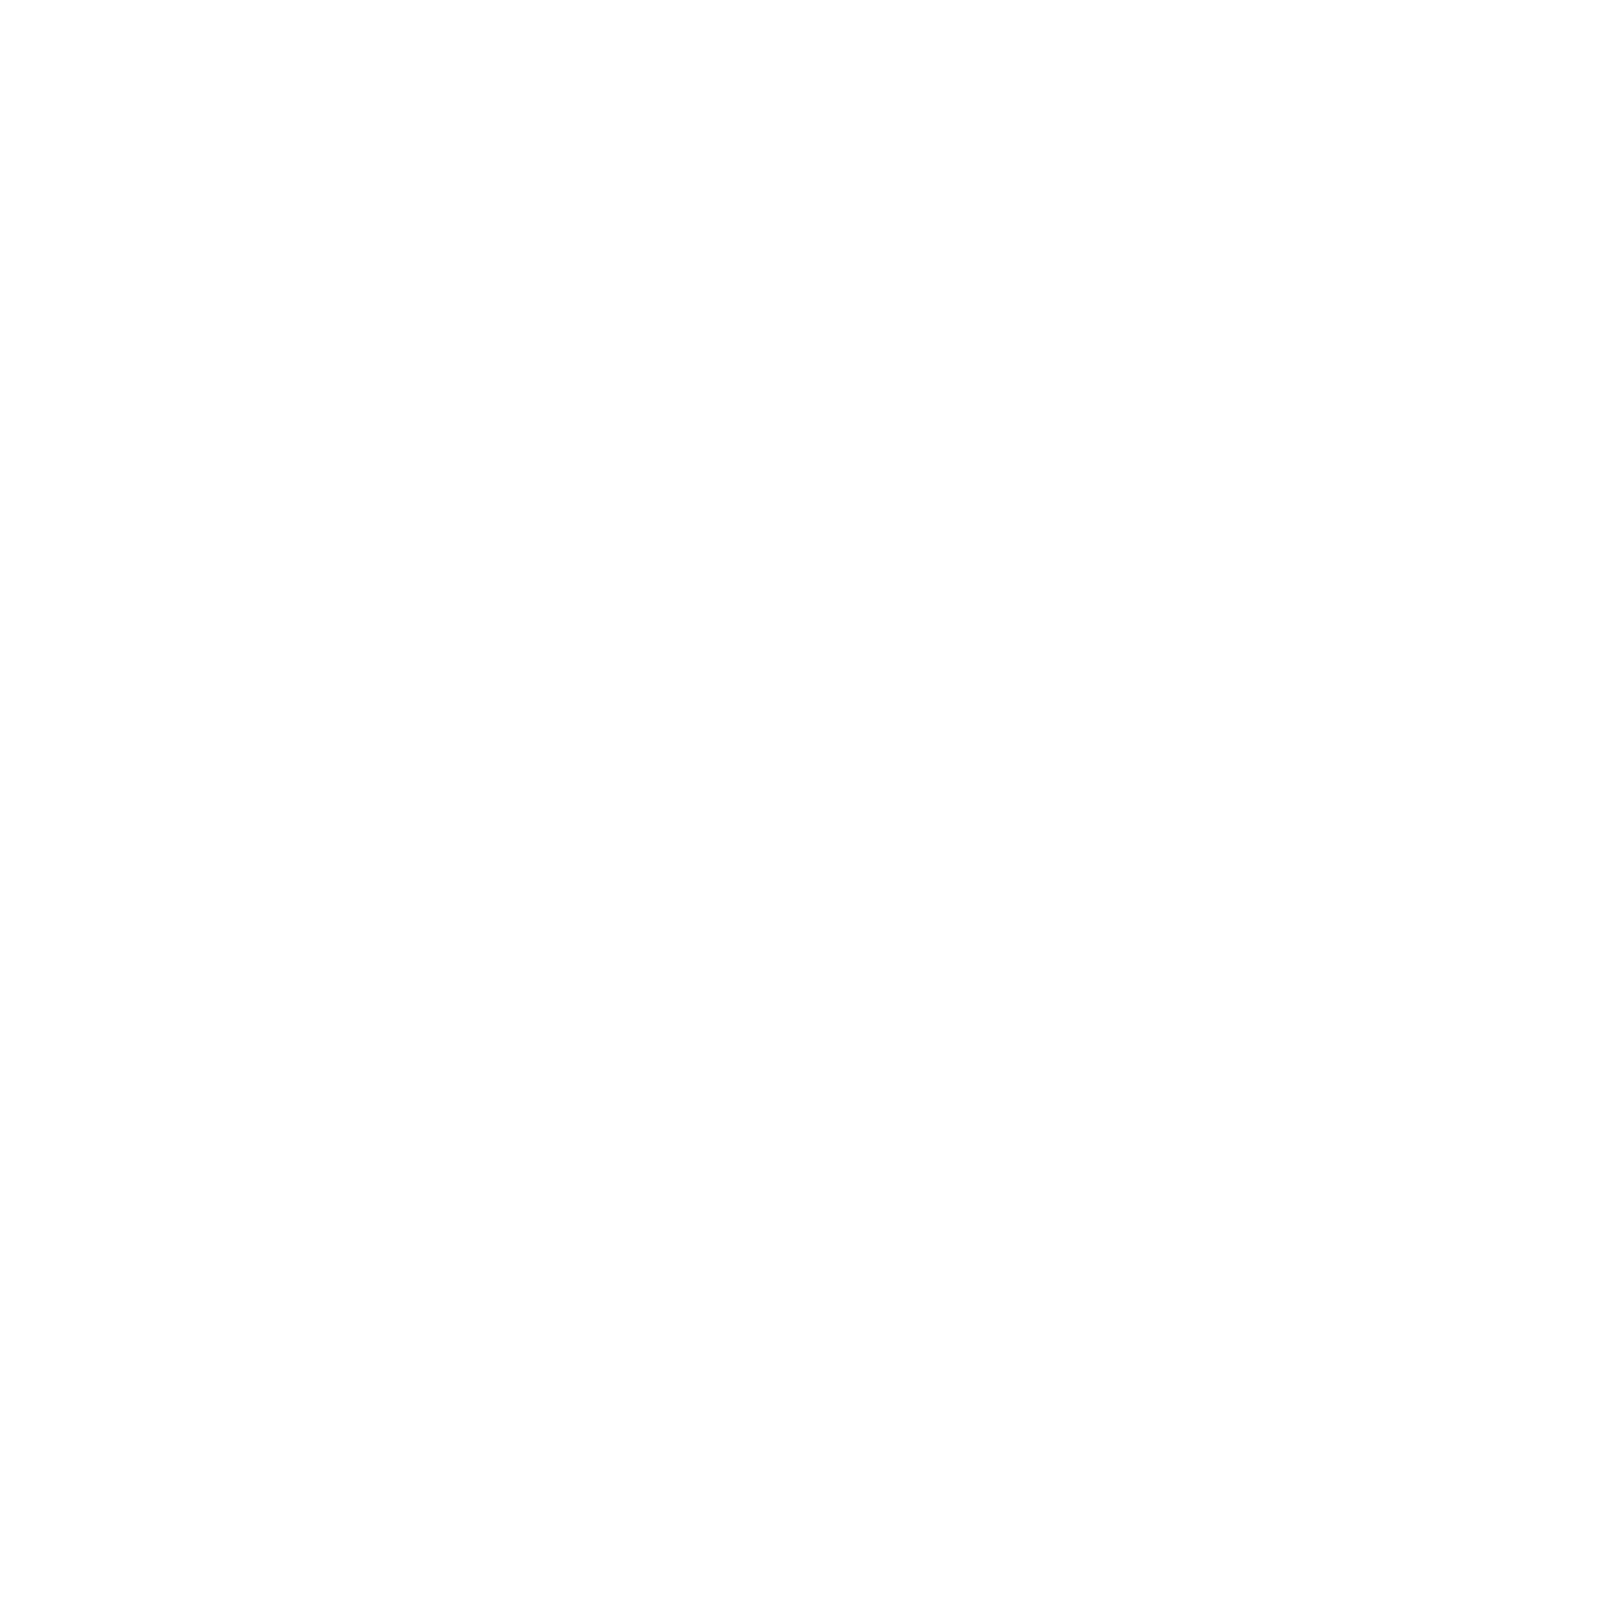

In [291]:
for obj in miniGoodObjDfMult['diaObjectId'].values[5:10]:
    plc.plotLightcurve(obj, miniGoodObjDf, repo, dbPath, repo, patchList, plotAllCutouts=True)